<a href="https://colab.research.google.com/github/ChunTingShen/DS4B_project/blob/main/Coupon_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#If opening in colab run this cell
#!git clone https://github.com/bwolfson2/dsclass2022
!git clone https://github.com/ChunTingShen/DS4B_project
import warnings
warnings.filterwarnings('ignore')
#%cd dsclass2022/Homeworks

Cloning into 'DS4B_project'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 61 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.


### Redeem Prediction:

Our target is to predict whether the promo code was redeemed on a purchase. The target variable is "y_redeemed" in the file proj_training_data.csv .

Since the data is already merged (thank you Prof!) , what we need to do next is to:

0. (define our target: predict "y_redeemed" )
1. clean the merged data: transform strings to date, strings(or float) to integer (for example: N_Children: 1.0, 2.0, 3+, Nan --> 1,2,3,-1)
2. (perform EDA: skip for now)
3. create dummy variable
4. create training and testing datasets
5. modeling
6. make predictions
7. evaluation
8. deployment

Overall, we think this is pretty close to the HW2. So we try to modify the HW2 code and do the analysis on this existing template. 



In [3]:
# imports

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set(style='ticks', palette='Set2')

import warnings
warnings.filterwarnings('ignore')



#Part 0. Data input

In [5]:
#input data:

# use the prof's version of data: 
path = "/content/proj_training_data.csv"

### path_sup = "/content/proj_training_data_supl.csv"
# not in use for now


import pandas as pd
import numpy as np

df = pd.read_csv(path)
print(len(df)) # should be 1102842
df.dropna()
df.drop_duplicates()

print(len(df))



1102842
1102842


## Adding date, DayOfWeek, month, day

In [6]:
### data cleaning:
from datetime import datetime
### convert date format:

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['start_date'] = pd.to_datetime(df['start_date'], format='%m/%d/%y')
df['end_date'] = pd.to_datetime(df['end_date'], format='%m/%d/%y')

### add Date of Week (0-6):
df['DayOfWeek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print(df.columns)

df.head()

Index(['y_redeemed', 'year', 'date', 'cust_id', 'prod_id', 'manuf',
       'brand_type', 'category', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 'c_id', 'c_type', 'start_date', 'end_date',
       'redemption_id', 'age_cohort', 'marital_status', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'DayOfWeek', 'month',
       'day'],
      dtype='object')


y_redeemed  year       date  cust_id  prod_id  manuf   brand_type category  \
0           0  2013 2013-02-22     1489    34047     56        Local  Grocery   
1           0  2013 2013-02-22     1489    35464     56        Local  Grocery   
2           0  2013 2013-03-03     1489    34047     56        Local  Grocery   
3           0  2013 2013-03-03     1489    33688    939  Established  Grocery   
4           0  2013 2013-03-05     1489    34047     56        Local  Grocery   

   y_qty   price  ...  redemption_id  age_cohort  marital_status  \
0      1   91.19  ...              9       46-55         Married   
1      1   21.02  ...              9       46-55         Married   
2      1   91.19  ...              9       46-55         Married   
3      1  124.31  ...              9       46-55         Married   
4      1   91.19  ...              9       46-55         Married   

  home_is_rental n_family no_of_children  income_range DayOfWeek month  day  
0            0.0      2.0            NaN           3.0         4     2   22  
1            0.0      2.0            NaN           3.0         4     2   22  
2            0.0      2.0            NaN           3.0         6     3    3  
3            0.0      2.0            NaN           3.0         6     3    3  
4            0.0      2.0            NaN           3.0         1     3    5  

[5 rows x 26 columns]

#Part 1. EDA:
#https://github.com/krsnewwave/coupon-redemption/blob/master/Marketing-Redemption-Prediction-EDA.ipynb

code (visualization) from github above


21792    119
13174     91
17453     82
28295     81
7532      81
Name: prod_id, dtype: int64

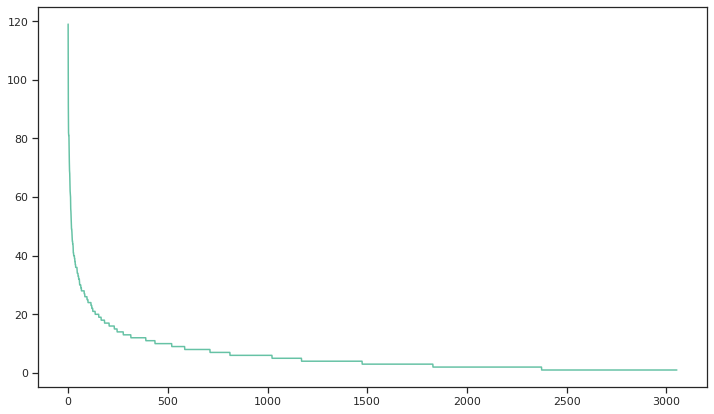

In [7]:
popular_coupons = df.loc[df["y_redeemed"] == 1, "prod_id"].value_counts()

display(popular_coupons.head())
plt.figure(figsize=(12, 7))
plt.plot(popular_coupons.values)




The redeemed coupon is related to product id. Which is pretty straightforward. Certain products with coupon are more appealing to customers than others.




8     15524
30     1469
5       804
29      280
2        58
Name: c_id, dtype: int64

7     16
3      7
1      6
28     5
27     4
Name: c_id, dtype: int64

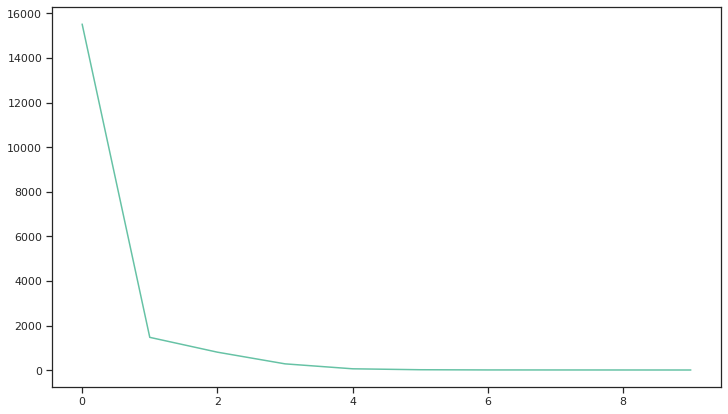

In [8]:
popular_coupons = df.loc[df["y_redeemed"] == 1, "c_id"].value_counts()

display(popular_coupons.head())
plt.figure(figsize=(12, 7))
plt.plot(popular_coupons.values)

display(popular_coupons.tail())



Certain campign are more appealing to others as well. 

In [12]:
path_pcode = "/content/DS4B_project/DS4Biz/ORIGINAL-FILES/code-redeemed-train.csv"

### path_sup = "/content/proj_training_data_supl.csv"
# not in use for now


import pandas as pd
import numpy as np

df_pcode = pd.read_csv(path_pcode)
print(len(df_pcode)) # should be 1102842
df_pcode.dropna()
df_pcode.drop_duplicates()

print(len(df_pcode))

44568
44568


754    19
661    14
9      14
6      10
705     8
Name: pcode_id, dtype: int64

821    1
800    1
783    1
974    1
392    1
Name: pcode_id, dtype: int64

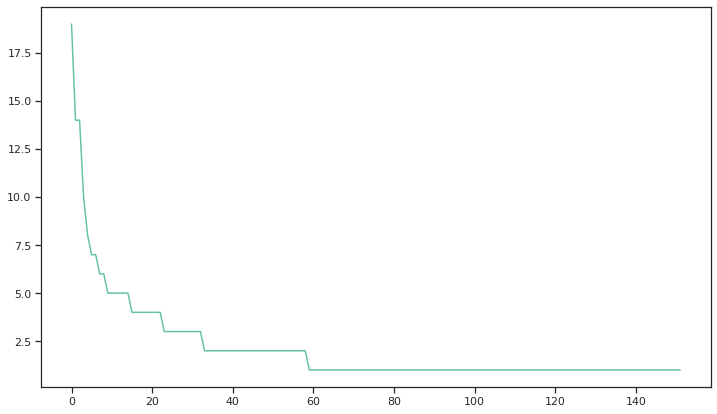

In [13]:
popular_coupons = df_pcode.loc[df_pcode["redeemed"] == 1, "pcode_id"].value_counts()

display(popular_coupons.head())
plt.figure(figsize=(12, 7))
plt.plot(popular_coupons.values)

display(popular_coupons.tail())


## Which income range would redeemd?

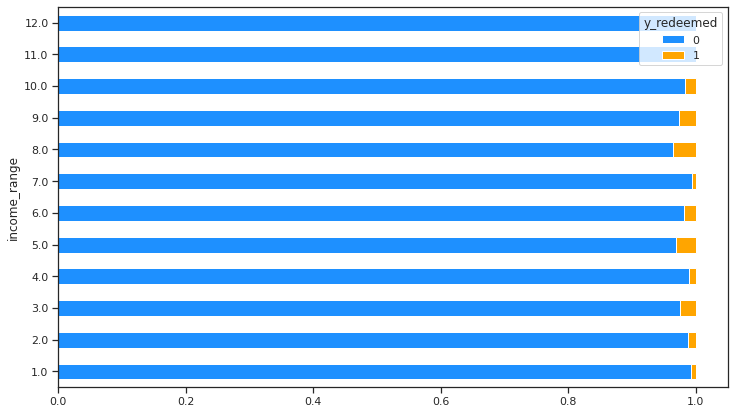

In [14]:
vc_redemption = df.groupby("income_range")["y_redeemed"].value_counts().unstack()

vc_redemption_pct = vc_redemption.div(vc_redemption.sum(axis=1), axis=0)

ax = plt.figure(figsize=(12, 7)).add_subplot(111)
vc_redemption_pct.plot.barh(stacked=True, color=['dodgerblue', 'orange'], ax=ax)
#ax.set_title("Percentage of redeemed coupons per income bracket. A higher income bracket indicates higher purchasing power.");

Roughly speaking, higher income_range indicates a higher rate to use coupon. However, it seems people in the top two tier (income_range 11 and 12) rarely redeem coupon. People in income_range = 7 and 4 rarely use coupon as well. 


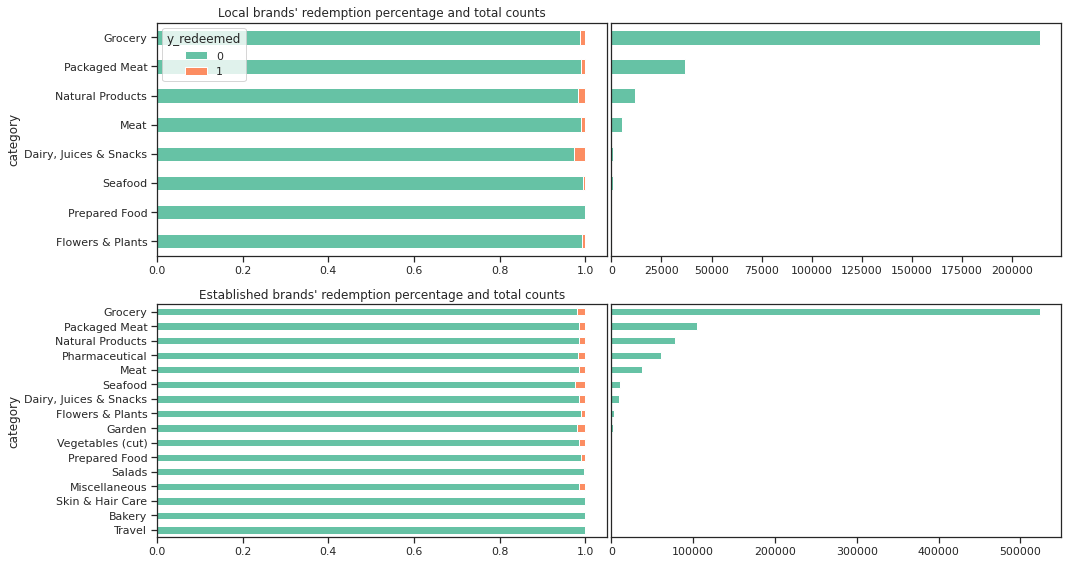

In [15]:
data_ct = df.groupby(["y_redeemed", "brand_type"])["category"].value_counts().unstack(level=0)
data_ct_pct = data_ct.div(data_ct.sum(axis=1), axis=0)

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# establish order
order = data_ct.sum(axis=1)["Local"].sort_values().index

# produce first pair plot: bar graph of all category types' local
data_ct_pct.xs("Local").loc[order].plot.barh(stacked=True, ax=axes[0][0])
data_ct.sum(axis=1).xs("Local").loc[order].plot.barh(stacked=True, ax=axes[0][1])
axes[0][0].set_title("Local brands' redemption percentage and total counts")

# establish order
order = data_ct.sum(axis=1)["Established"].sort_values().index

# produce second pair plot: bar graph of all category types' established
data_ct_pct.xs("Established").loc[order].plot.barh(stacked=True, ax=axes[1][0])
data_ct.sum(axis=1).xs("Established").loc[order].plot.barh(stacked=True, ax=axes[1][1])
axes[1][0].set_title("Established brands' redemption percentage and total counts")

fig.tight_layout()
fig.subplots_adjust(wspace=0.01)

axes[0][1].set_ylabel("")
axes[0][1].set_yticks([])
axes[1][1].set_ylabel("")
axes[1][1].set_yticks([])
axes[1][0].get_legend().remove();


#Part 2. Data wrangling:

## Replace 'Nan' to something else

In [16]:

########## convert type from float or string to integer: 
df['marital_status'] = df['marital_status'].replace(np.nan, -1) # replace no values as -1

df['home_is_rental'] = df['home_is_rental'].replace(np.nan, -1)
df['home_is_rental'] = df['home_is_rental'].astype(int)

df['age_cohort'] = df['age_cohort'].replace(np.nan, -1)
df['age_cohort'] = df['age_cohort'].replace("18-25", "18_25") 
df['age_cohort'] = df['age_cohort'].replace("26-35", "26_35")
df['age_cohort'] = df['age_cohort'].replace("36-45", "36_45")
df['age_cohort'] = df['age_cohort'].replace("46-55", "46_55")
df['age_cohort'] = df['age_cohort'].replace("56-70", "56_70")
df['age_cohort'] = df['age_cohort'].replace("70+", "71")


df['n_family'] = df['n_family'].replace(np.nan, -1)
df['n_family'] = df['n_family'].replace("5+", 5)
df['n_family'] = df['n_family'].astype(int)


df['no_of_children'] = df['no_of_children'].replace(np.nan, -1) # if no response: label it as -1 
df['no_of_children'] = df['no_of_children'].replace("3+", 3)
df['no_of_children'] = df['no_of_children'].astype(int)


df['income_range'] = df['income_range'].replace(np.nan, -1)
df['income_range'] = df['income_range'].astype(int)


print(len(df))

# create promotion days:
df["promo_duration"] = df['end_date'] - df['start_date']
df["promo_duration"] = df["promo_duration"].dt.days

df["promo_start"] = df['date'] - df['start_date']
df["promo_start"] = df["promo_start"].dt.days




print(df.columns)

df[:-5]

1102842
Index(['y_redeemed', 'year', 'date', 'cust_id', 'prod_id', 'manuf',
       'brand_type', 'category', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 'c_id', 'c_type', 'start_date', 'end_date',
       'redemption_id', 'age_cohort', 'marital_status', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'DayOfWeek', 'month',
       'day', 'promo_duration', 'promo_start'],
      dtype='object')


y_redeemed  year       date  cust_id  prod_id  manuf   brand_type  \
0                 0  2013 2013-02-22     1489    34047     56        Local   
1                 0  2013 2013-02-22     1489    35464     56        Local   
2                 0  2013 2013-03-03     1489    34047     56        Local   
3                 0  2013 2013-03-03     1489    33688    939  Established   
4                 0  2013 2013-03-05     1489    34047     56        Local   
...             ...   ...        ...      ...      ...    ...          ...   
1102832           0  2013 2013-03-18      436    31922    524  Established   
1102833           0  2013 2013-03-26      436    26122     56        Local   
1102834           0  2013 2013-03-29      436     7479    803  Established   
1102835           0  2013 2013-02-17      436    17444   1470  Established   
1102836           0  2013 2013-02-20      436     7479    803  Established   

               category  y_qty   price  ...  marital_status  home_is_rental  \
0               Grocery      1   91.19  ...         Married               0   
1               Grocery      1   21.02  ...         Married               0   
2               Grocery      1   91.19  ...         Married               0   
3               Grocery      1  124.31  ...         Married               0   
4               Grocery      1   91.19  ...         Married               0   
...                 ...    ...     ...  ...             ...             ...   
1102832         Grocery      1   66.97  ...         Married               0   
1102833   Packaged Meat      1   89.05  ...         Married               0   
1102834         Grocery      2  184.51  ...         Married               0   
1102835  Pharmaceutical      2  569.21  ...         Married               0   
1102836         Grocery      3  276.77  ...         Married               0   

         n_family no_of_children income_range DayOfWeek  month day  \
0               2             -1            3         4      2  22   
1               2             -1            3         4      2  22   
2               2             -1            3         6      3   3   
3               2             -1            3         6      3   3   
4               2             -1            3         1      3   5   
...           ...            ...          ...       ...    ...  ..   
1102832         2             -1            8         0      3  18   
1102833         2             -1            8         1      3  26   
1102834         2             -1            8         4      3  29   
1102835         2             -1            8         6      2  17   
1102836         2             -1            8         2      2  20   

        promo_duration  promo_start  
0                   77            6  
1                   77            6  
2                   77           15  
3                   77           15  
4                   77           17  
...                ...          ...  
1102832            133          119  
1102833            133          127  
1102834            133          130  
1102835            133           90  
1102836            133           93  

[1102837 rows x 28 columns]

(It used to be EDA here. But they looks quite messy so I moved them to the section below)

## Transform price to Log(price)

In [17]:
### add log price

df['lnPrice'] = np.log(df.price+1)           # add 1 to account for for zero sales days (don't think exists here)

### separate testing and training  data by date 
df_test  = df[df['date'] >= '2013/4/5']
df_train = df[df['date'] < '2013/4/5']




target_col = "y_redeemed"
predictor_cols = ["redemption_id", "age_cohort", "income_range", "brand_type", "category", "marital_status"]
print(df_train.columns)

df_train[:-5]


Index(['y_redeemed', 'year', 'date', 'cust_id', 'prod_id', 'manuf',
       'brand_type', 'category', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 'c_id', 'c_type', 'start_date', 'end_date',
       'redemption_id', 'age_cohort', 'marital_status', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'DayOfWeek', 'month',
       'day', 'promo_duration', 'promo_start', 'lnPrice'],
      dtype='object')


y_redeemed  year       date  cust_id  prod_id  manuf   brand_type  \
0                 0  2013 2013-02-22     1489    34047     56        Local   
1                 0  2013 2013-02-22     1489    35464     56        Local   
2                 0  2013 2013-03-03     1489    34047     56        Local   
3                 0  2013 2013-03-03     1489    33688    939  Established   
4                 0  2013 2013-03-05     1489    34047     56        Local   
...             ...   ...        ...      ...      ...    ...          ...   
1102832           0  2013 2013-03-18      436    31922    524  Established   
1102833           0  2013 2013-03-26      436    26122     56        Local   
1102834           0  2013 2013-03-29      436     7479    803  Established   
1102835           0  2013 2013-02-17      436    17444   1470  Established   
1102836           0  2013 2013-02-20      436     7479    803  Established   

               category  y_qty   price  ...  home_is_rental  n_family  \
0               Grocery      1   91.19  ...               0         2   
1               Grocery      1   21.02  ...               0         2   
2               Grocery      1   91.19  ...               0         2   
3               Grocery      1  124.31  ...               0         2   
4               Grocery      1   91.19  ...               0         2   
...                 ...    ...     ...  ...             ...       ...   
1102832         Grocery      1   66.97  ...               0         2   
1102833   Packaged Meat      1   89.05  ...               0         2   
1102834         Grocery      2  184.51  ...               0         2   
1102835  Pharmaceutical      2  569.21  ...               0         2   
1102836         Grocery      3  276.77  ...               0         2   

         no_of_children income_range DayOfWeek month  day promo_duration  \
0                    -1            3         4     2   22             77   
1                    -1            3         4     2   22             77   
2                    -1            3         6     3    3             77   
3                    -1            3         6     3    3             77   
4                    -1            3         1     3    5             77   
...                 ...          ...       ...   ...  ...            ...   
1102832              -1            8         0     3   18            133   
1102833              -1            8         1     3   26            133   
1102834              -1            8         4     3   29            133   
1102835              -1            8         6     2   17            133   
1102836              -1            8         2     2   20            133   

        promo_start   lnPrice  
0                 6  4.523852  
1                 6  3.091951  
2                15  4.523852  
3                15  4.830791  
4                17  4.523852  
...             ...       ...  
1102832         119  4.219066  
1102833         127  4.500365  
1102834         130  5.223109  
1102835          90  6.346005  
1102836          93  5.626793  

[953164 rows x 29 columns]

In [18]:
print(len(df_train))
print(len(df_test))

953169
149673


In [19]:
print(len(df))
df[:10]
df["promo_duration"][:10]

1102842


0    77
1    77
2    77
3    77
4    77
5    77
6    77
7    77
8    77
9    77
Name: promo_duration, dtype: int64

The records starts from 2012/01/10 until 2013/04/14.

Here we can do a series of preliminary analyses. 

First, we take the 2013/1/10 as the cutting point (so we have a full year as training data). 

Records after 2013/1/10 will be testing data and before 2013/1/10 will be our training data. 


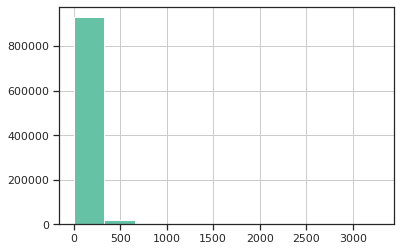

In [20]:
df_train['price'].hist()

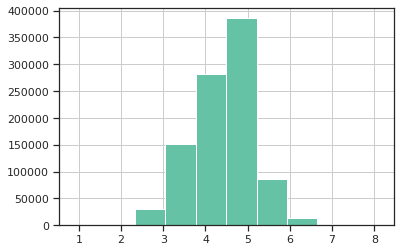

In [21]:
#max(df_train['date'])
#df_train[:-10]

df_train['lnPrice'].hist()                                # make sure everything looks OK


##Create dummy variables (for logistic regression):


In [22]:
df_dummy = df


In [23]:

df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['marital_status'], drop_first=True, prefix = "marital_status")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['category'], drop_first=True, prefix = "category")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['brand_type'], drop_first=True, prefix = "brand_type")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['age_cohort'], drop_first=True, prefix = "age_cohort")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['home_is_rental'], drop_first=True, prefix = "home_is_rental")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['n_family'], drop_first=True, prefix = "n_family")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['no_of_children'], drop_first=True, prefix = "no_of_children")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['income_range'], drop_first=True, prefix = "income_range")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['DayOfWeek'], drop_first=True, prefix = "DOW")))], axis = 1, join = 'inner')
df_dummy = pd.concat([df_dummy, ((pd.get_dummies(df_dummy['c_type'], drop_first=True, prefix = "c_type")))], axis = 1, join = 'inner')


In [24]:
df_dummy[:5]

y_redeemed  year       date  cust_id  prod_id  manuf   brand_type category  \
0           0  2013 2013-02-22     1489    34047     56        Local  Grocery   
1           0  2013 2013-02-22     1489    35464     56        Local  Grocery   
2           0  2013 2013-03-03     1489    34047     56        Local  Grocery   
3           0  2013 2013-03-03     1489    33688    939  Established  Grocery   
4           0  2013 2013-03-05     1489    34047     56        Local  Grocery   

   y_qty   price  ...  income_range_10  income_range_11  income_range_12  \
0      1   91.19  ...                0                0                0   
1      1   21.02  ...                0                0                0   
2      1   91.19  ...                0                0                0   
3      1  124.31  ...                0                0                0   
4      1   91.19  ...                0                0                0   

  DOW_1 DOW_2 DOW_3  DOW_4 DOW_5 DOW_6  c_type_Y  
0     0     0     0      1     0     0         0  
1     0     0     0      1     0     0         0  
2     0     0     0      0     0     1         0  
3     0     0     0      0     0     1         0  
4     1     0     0      0     0     0         0  

[5 rows x 82 columns]

## (Optional) Build a simple tree to see what might happened.



In [25]:
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [26]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 
    

In [27]:
def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]


import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 

def visualize_tree(decision_tree, feature_names, class_names, directory="/content/DS4B_project/DS4Biz/images/", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

In [30]:

from sklearn.tree import DecisionTreeClassifier
# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=10, criterion="entropy")   # Look at those 2 arguments !!! 
# Let's tell the model what is the data

predictor_cols = ['year', 'cust_id', 'prod_id', 'manuf', 'price', 'dscnt_store',
       'home_is_rental', 'DayOfWeek', 'month', 'day', 'promo_duration',
       'promo_start', 'lnPrice', 'marital_status_Married',
       'marital_status_Single', 'category_Dairy, Juices & Snacks',
       'category_Flowers & Plants', 'category_Garden', 'category_Grocery',
       'category_Meat', 'category_Miscellaneous', 'category_Natural Products',
       'category_Packaged Meat', 'category_Pharmaceutical',
       'category_Prepared Food', 'category_Salads', 'category_Seafood',
       'category_Skin & Hair Care', 'category_Travel',
       'category_Vegetables (cut)', 'brand_type_Local', 'age_cohort_18_25',
       'age_cohort_26_35', 'age_cohort_36_45', 'age_cohort_46_55',
       'age_cohort_56_70', 'age_cohort_71', 'home_is_rental_0',
       'home_is_rental_1', 'n_family_1', 'n_family_2', 'n_family_3',
       'n_family_4', 'n_family_5', 'no_of_children_1', 'no_of_children_2',
       'no_of_children_3', 'income_range_1', 'income_range_2',
       'income_range_3', 'income_range_4', 'income_range_5', 'income_range_6',
       'income_range_7', 'income_range_8', 'income_range_9', 'income_range_10',
       'income_range_11', 'income_range_12', 'DOW_1', 'DOW_2', 'DOW_3',
       'DOW_4', 'DOW_5', 'DOW_6', 'c_type_Y']


decision_tree.fit(df_dummy[predictor_cols], df_dummy[target_col])





DecisionTreeClassifier(criterion='entropy', max_depth=10)

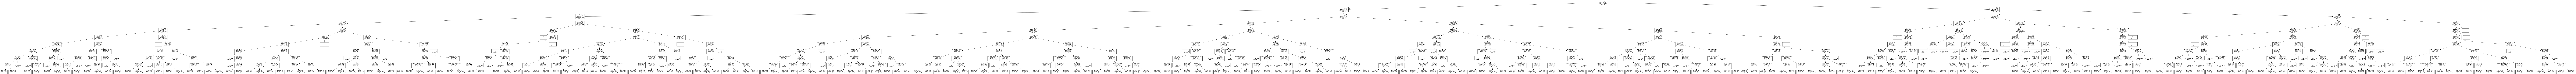

In [31]:
from IPython.display import Image
from sklearn.tree import export_graphviz

visualize_tree(decision_tree, predictor_cols, ["no", "redeemed"])

Notice every leaf node are labeled as no redemption. That might due to the fact that 99% of the data are no redemption and only around 1% are actually redeemed. 

Maybe we should create more levels? or maybe we should turn to some other methods?


## Divide training data and testing data


In [32]:
# check the max date
#max(df['date']) #Timestamp('2013-04-14 00:00:00')
#min(df['date']) #Timestamp('2012-01-10 00:00:00')



#df_train = df.loc[df["date"] < '2013-04-04']
#df_valid = df.loc[df["date"] >= '2013-04-04']



df_train_dummy = df_dummy.loc[df_dummy["date"] < '2013-04-04']
df_valid_dummy = df_dummy.loc[df_dummy["date"] >= '2013-04-04']


print(len(df_train_dummy))
print(len(df_valid_dummy))


938493
164349


In [33]:
# df_train_dummy 
from sklearn.model_selection import train_test_split


index_cols = ['y_qty', 'y_dscnt_pcode', 'redemption_id', 'date', 'brand_type', 'category', 'c_type', 'c_id', 'marital_status', 'income_range', 'n_family', 'no_of_children', 'start_date', 'end_date', 'age_cohort']
feature_cols = df_train_dummy.drop(columns=index_cols + [target_col])

X = feature_cols
y = df_train_dummy['y_redeemed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)

print(X_train.columns)

X_train[:5]

Index(['year', 'cust_id', 'prod_id', 'manuf', 'price', 'dscnt_store',
       'home_is_rental', 'DayOfWeek', 'month', 'day', 'promo_duration',
       'promo_start', 'lnPrice', 'marital_status_Married',
       'marital_status_Single', 'category_Dairy, Juices & Snacks',
       'category_Flowers & Plants', 'category_Garden', 'category_Grocery',
       'category_Meat', 'category_Miscellaneous', 'category_Natural Products',
       'category_Packaged Meat', 'category_Pharmaceutical',
       'category_Prepared Food', 'category_Salads', 'category_Seafood',
       'category_Skin & Hair Care', 'category_Travel',
       'category_Vegetables (cut)', 'brand_type_Local', 'age_cohort_18_25',
       'age_cohort_26_35', 'age_cohort_36_45', 'age_cohort_46_55',
       'age_cohort_56_70', 'age_cohort_71', 'home_is_rental_0',
       'home_is_rental_1', 'n_family_1', 'n_family_2', 'n_family_3',
       'n_family_4', 'n_family_5', 'no_of_children_1', 'no_of_children_2',
       'no_of_children_3', 'income_range

year  cust_id  prod_id  manuf   price  dscnt_store  home_is_rental  \
543897  2013      634    28656    602  156.37         0.00               0   
18498   2013     1475    16708    967   59.49       -20.66               0   
232223  2013     1516    33448     56   70.88         0.00              -1   
67601   2013       40    67629   3099  314.17      -157.80               0   
368655  2013      181    15227   2020   89.05       -53.07              -1   

        DayOfWeek  month  day  ...  income_range_10  income_range_11  \
543897          3      2   21  ...                0                0   
18498           1      3   12  ...                0                0   
232223          4      3   22  ...                0                0   
67601           2      3    6  ...                0                0   
368655          4      3   15  ...                0                0   

        income_range_12  DOW_1  DOW_2  DOW_3  DOW_4  DOW_5  DOW_6  c_type_Y  
543897                0      0      0      1      0      0      0         0  
18498                 0      1      0      0      0      0      0         0  
232223                0      0      0      0      1      0      0         0  
67601                 0      0      1      0      0      0      0         0  
368655                0      0      0      0      1      0      0         0  

[5 rows x 66 columns]

In [61]:
# prepare df_valid_dummy for later validation

from sklearn.model_selection import train_test_split


index_cols = ['y_qty', 'y_dscnt_pcode', 'redemption_id', 'date', 'brand_type', 'category', 'c_type', 'c_id', 'marital_status', 'income_range', 'n_family', 'no_of_children', 'start_date', 'end_date', 'age_cohort']
feature_cols = df_valid_dummy.drop(columns=index_cols + [target_col])

X_valid = feature_cols
y_valid = df_valid_dummy['y_redeemed']


In [34]:
y_train.value_counts()

0    738374
1     12420
Name: y_redeemed, dtype: int64

In [130]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

##(Not sure) Undersampling:  cluster
The dataset is very imbalanced. Less than 1% of the records are "redeemed".
So we may want to replace those 99% "not redeemed" with clusters, then make  X_train and y_train into similar size. 



In [35]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour


#undersampler = ClusterCentroids()  # this takes too long!!!
#undersampler = TomekLinks(n_jobs=3)
X_train.shape


(750794, 66)

In [36]:
### WARNING: this is not very efficient. I ran over an hour and did not finished!!!

###X_cc, y_cc = undersampler.fit_resample(X_train, y_train) # take too long!!!

In [ ]:
#y_cc.value_counts()

### Random Under Sample: 
Randomly pick "y_redeemed" = 0 until the data length match "y_redeemed" = 1.

Very quick solution, but is not very reliable. May not reproduce the same results. 


In [37]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [38]:
y_rus.value_counts()

0    12420
1    12420
Name: y_redeemed, dtype: int64

In [39]:
X_rus[:10]

year  cust_id  prod_id  manuf   price  dscnt_store  home_is_rental  \
0  2013      413    68361    676  248.98       -17.81              -1   
1  2013      957    36662     56   35.62        -1.78               0   
2  2012     1095    25113   1149   14.25         0.00              -1   
3  2013      293    24313     56  142.48         0.00               0   
4  2013     1392    36213    982  195.55       -17.81               0   
5  2013      737     5315    967   59.49       -20.66               0   
6  2013      626    34190   1143   35.62         0.00               0   
7  2012     1485    50828    522   71.24       -67.32               0   
8  2013      525    32625    634   99.38         0.00               0   
9  2012      226    53099   1101  427.08       -35.62               0   

   DayOfWeek  month  day  ...  income_range_10  income_range_11  \
0          5      3   16  ...                0                0   
1          1      2   12  ...                0                0   
2          1      5   29  ...                0                0   
3          5      2    9  ...                0                0   
4          4      3   15  ...                0                0   
5          0      3   18  ...                0                0   
6          6      2   17  ...                0                0   
7          6     10   14  ...                0                0   
8          3      2   28  ...                0                0   
9          4      7   20  ...                0                0   

   income_range_12  DOW_1  DOW_2  DOW_3  DOW_4  DOW_5  DOW_6  c_type_Y  
0                0      0      0      0      0      1      0         0  
1                0      1      0      0      0      0      0         0  
2                0      1      0      0      0      0      0         1  
3                0      0      0      0      0      1      0         0  
4                0      0      0      0      1      0      0         0  
5                0      0      0      0      0      0      0         0  
6                0      0      0      0      0      0      1         0  
7                0      0      0      0      0      0      1         1  
8                0      0      0      1      0      0      0         0  
9                0      0      0      0      1      0      0         1  

[10 rows x 66 columns]

###  SMOTE: Oversample?
Create (or duplicate) more data for the "redeemed". 

In [40]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [41]:
y_smote.value_counts() #738374

0    738374
1    738374
Name: y_redeemed, dtype: int64

#Part 3. Models


## Define Helper functions

In [42]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, classification_report, confusion_matrix, average_precision_score
from sklearn.pipeline import make_pipeline


In [43]:
#helper func to build graph
def plot_roc(fpr,tpr,roc_auc):
  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkblue",
      lw=lw,
      label="ROC curve (area = %0.4f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic")
  plt.legend(loc="lower right")
  plt.show()

In [44]:

scoring_metrics = ['roc_auc', 'neg_log_loss', 'balanced_accuracy', 'average_precision']
# todo, the cross validate function only uses the predict function and not the predict -proba
def testing_suite(estimator, X_train, y_train, X_test, y_test, scoring_metrics = scoring_metrics):
    test_scores = cross_validate(estimator, X_train, y_train, scoring=scoring_metrics, cv=5)
    display(pd.DataFrame(test_scores))
        
    estimator.fit(X, y)
    
    print(classification_report(y_test, estimator.predict(X_test)))
    print("Log loss:", log_loss(y_test, estimator.predict_proba(X_test)))
    print("ROC:", roc_auc_score(y_test, estimator.predict_proba(X_test)[:, 1]))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, estimator.predict(X_test)))
    print("Average Precision:", average_precision_score(y_test, estimator.predict_proba(X_test)[:,1]))
    
    display(pd.DataFrame(confusion_matrix(y_test, estimator.predict(X_test)), index=["True0", "True1"], columns=["Prediction0", "Prediction1"]))
    
    return estimator

## I. Logic regression

In [45]:
# here we need to use "df_dummy"
df_dummy_train = df_dummy.loc[df_dummy["date"] < '2013-04-04']
df_dummy_valid = df_dummy.loc[df_dummy["date"] >= '2013-04-04']

print(len(df_dummy_train))
print(len(df_dummy_valid))


938493
164349


In [46]:
from sklearn.model_selection import train_test_split


index_cols = ['y_qty', 'y_dscnt_pcode', 'redemption_id', 'date', 'brand_type', 'category', 'c_type', 'c_id', 'marital_status', 'income_range', 'n_family', 'no_of_children', 'start_date', 'end_date', 'age_cohort']
feature_cols = df_dummy_train.drop(columns=index_cols + [target_col])

X = feature_cols
y = df_dummy_train['y_redeemed']

X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)


X_dummy_training = X_dummy_train.join(y_dummy_train, how = 'left')

print(X_dummy_training.columns)

X_dummy_training[:5]

Index(['year', 'cust_id', 'prod_id', 'manuf', 'price', 'dscnt_store',
       'home_is_rental', 'DayOfWeek', 'month', 'day', 'promo_duration',
       'promo_start', 'lnPrice', 'marital_status_Married',
       'marital_status_Single', 'category_Dairy, Juices & Snacks',
       'category_Flowers & Plants', 'category_Garden', 'category_Grocery',
       'category_Meat', 'category_Miscellaneous', 'category_Natural Products',
       'category_Packaged Meat', 'category_Pharmaceutical',
       'category_Prepared Food', 'category_Salads', 'category_Seafood',
       'category_Skin & Hair Care', 'category_Travel',
       'category_Vegetables (cut)', 'brand_type_Local', 'age_cohort_18_25',
       'age_cohort_26_35', 'age_cohort_36_45', 'age_cohort_46_55',
       'age_cohort_56_70', 'age_cohort_71', 'home_is_rental_0',
       'home_is_rental_1', 'n_family_1', 'n_family_2', 'n_family_3',
       'n_family_4', 'n_family_5', 'no_of_children_1', 'no_of_children_2',
       'no_of_children_3', 'income_range

year  cust_id  prod_id  manuf   price  dscnt_store  home_is_rental  \
543897  2013      634    28656    602  156.37         0.00               0   
18498   2013     1475    16708    967   59.49       -20.66               0   
232223  2013     1516    33448     56   70.88         0.00              -1   
67601   2013       40    67629   3099  314.17      -157.80               0   
368655  2013      181    15227   2020   89.05       -53.07              -1   

        DayOfWeek  month  day  ...  income_range_11  income_range_12  DOW_1  \
543897          3      2   21  ...                0                0      0   
18498           1      3   12  ...                0                0      1   
232223          4      3   22  ...                0                0      0   
67601           2      3    6  ...                0                0      0   
368655          4      3   15  ...                0                0      0   

        DOW_2  DOW_3  DOW_4  DOW_5  DOW_6  c_type_Y  y_redeemed  
543897      0      1      0      0      0         0           0  
18498       0      0      0      0      0         0           0  
232223      0      0      1      0      0         0           0  
67601       1      0      0      0      0         0           0  
368655      0      0      1      0      0         0           0  

[5 rows x 67 columns]

In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


#f   = 'y_redeemed ~ lnPrice + dscnt_store + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + home_is_rental_1 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + DOW_1 + DOW_2 + DOW_3 + DOW_4 + DOW_5 + DOW_6 + promo_start'
# Note: still having singuler matrix issue on the "dayofweek" columns

#f   = 'y_redeemed ~ lnPrice + month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + home_is_rental_1 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'
#f   = 'y_redeemed ~ month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + home_is_rental_1 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'
# note: if exclude null, run below:

f   = 'y_redeemed ~ month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Single + home_is_rental_1 + home_is_rental_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_11 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'


model_ols_sm = smf.logit(f, data=X_dummy_training).fit()
print(model_ols_sm.summary())

pred = model_ols_sm.predict(X_dummy_test)


         Current function value: 0.080508
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:             y_redeemed   No. Observations:               750794
Model:                          Logit   Df Residuals:                   750759
Method:                           MLE   Df Model:                           34
Date:                Thu, 28 Apr 2022   Pseudo R-squ.:                 0.04452
Time:                        04:36:52   Log-Likelihood:                -60445.
converged:                      False   LL-Null:                       -63261.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -4.6445      0.039   -119.611      0.000      -4.721      -4.568
month                      -0.0499      0.004    -11.503      0.000      -0.058      -0.041


#### AUC: 0.6316 (imbalanced data)

Accuracy (sklearn): 0.67506


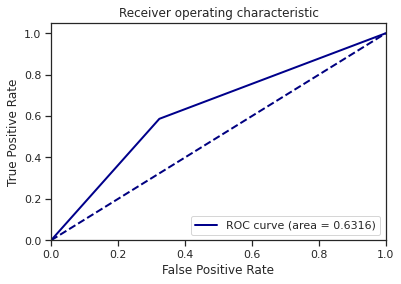

In [51]:


import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score


p_baseline = np.mean(X_dummy_training['y_redeemed'])
pred_bin = np.where(pred > p_baseline, 1, 0)
#pred_zero = [0 for i in range(len(pred))]

#pred              = pred[]] #column used for predicted
act               = y_dummy_test #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


model_logit_accuracy = metrics.accuracy_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

###If we balance the data?




In [52]:

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_smote_dummy, y_smote_dummy = sm.fit_resample(X_dummy_train, y_dummy_train)


In [143]:
f   = 'y_redeemed ~ month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Single + home_is_rental_1 + home_is_rental_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_11 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'

X_smote_train = X_smote_dummy.join(y_smote_dummy, how = 'left')

model_ols_sm = smf.logit(f, data=X_smote_train).fit()
print(model_ols_sm.summary())

pred = model_ols_sm.predict(X_dummy_test)

         Current function value: 0.630386
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             y_redeemed   No. Observations:              1476748
Model:                          Logit   Df Residuals:                  1476712
Method:                           MLE   Df Model:                           35
Date:                Thu, 28 Apr 2022   Pseudo R-squ.:                 0.09054
Time:                        01:17:52   Log-Likelihood:            -9.3092e+05
converged:                      False   LL-Null:                   -1.0236e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3945      0.007     56.281      0.000       0.381       0.408
month                     

Accuracy (sklearn): 0.54801


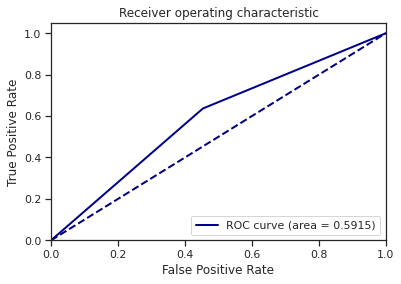

In [144]:
p_baseline = np.mean(X_smote_train['y_redeemed'])
pred_bin = np.where(pred > p_baseline, 1, 0)
#pred_zero = [0 for i in range(len(pred))]

#pred              = pred[]] #column used for predicted
act               = y_dummy_test #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


model_logit_accuracy = metrics.accuracy_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

#### AUC: 0.5915

### use sklearn.linear_model.LogisticRegression

In [53]:
from sklearn.linear_model import LogisticRegression

#clf = LogisticRegression(random_state=0).fit(X_smote, y_smote)       # SMOTE
#clf = LogisticRegression(random_state=0).fit(X_rus, y_rus)         # RUS
clf = LogisticRegression(random_state=0).fit(X_dummy_train, y_dummy_train)  # original
#clf = LogisticRegression(random_state=0).fit(X_smote_dummy, y_smote_dummy)       # SMOTE


In [54]:
#pred = clf.predict(X_dummy_test)
pred = clf.predict_proba(X_dummy_test)[:, 1]

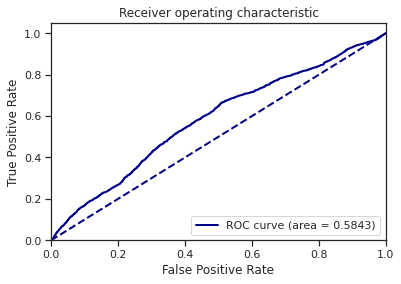

In [55]:
# graph
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

act               = y_test #column used for actual

act               = y_dummy_test #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function

#model_logit_accuracy = metrics.accuracy_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

#### AUC: 0.5781 (by original data), 0.5843 probability
#### AUC: 0.5732 (by Random Under Sample data)
#### AUC: 0.5749 (by SMOTE data)


### some other methods

fit_time  score_time  test_roc_auc  test_neg_log_loss  \
0  26.834403    0.488039      0.716700          -0.175111   
1  18.484442    0.680069      0.717437          -0.175007   
2  13.848287    0.472889      0.713830          -0.174853   
3  12.842377    0.472886      0.707922          -0.175441   
4  27.292107    0.754113      0.705990          -0.175620   

   test_balanced_accuracy  test_average_precision  
0                0.504816                0.038904  
1                0.504278                0.041831  
2                0.502565                0.040853  
3                0.505822                0.039474  
4                0.507395                0.038506

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    184513
           1       0.07      0.02      0.03      3186

    accuracy                           0.98    187699
   macro avg       0.53      0.51      0.51    187699
weighted avg       0.97      0.98      0.97    187699

Log loss: 0.17624646264495003
ROC: 0.7111682229920879
Balanced Accuracy: 0.5063882363252983
Average Precision: 0.040486657930121336


Prediction0  Prediction1
True0       183801          712
True1         3133           53

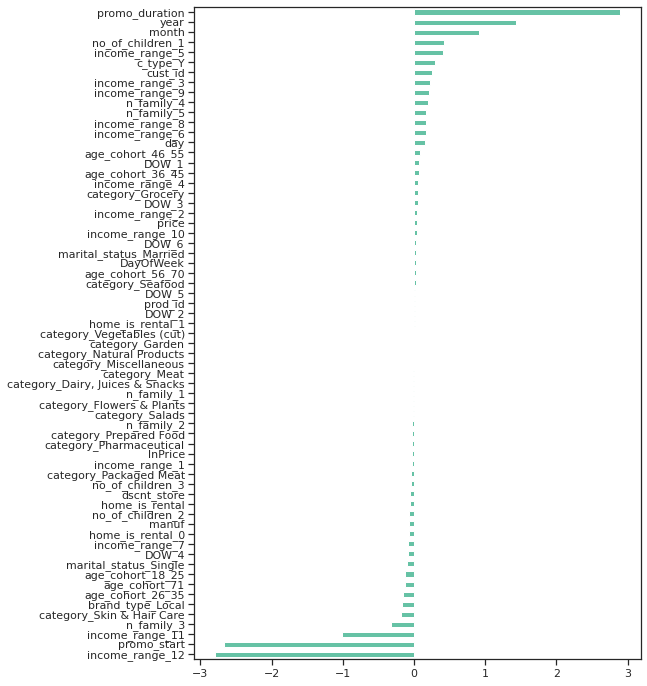

In [56]:
lr = LogisticRegression(solver = 'lbfgs', max_iter=300, class_weight={0 : 1, 1 : 10})
pipeline = make_pipeline(StandardScaler(), lr)

pipeline = testing_suite(pipeline, X_train, y_train, X_test, y_test)
series_coef = pd.Series(pipeline.steps[1][1].coef_.ravel(), index=X_train.columns,).sort_values()
plt.figure(figsize=(8, 12))
top_coef = series_coef[abs(series_coef) > 1e-4]
top_coef.plot.barh()

## II. GradientBoostingClassifier 
Another interesting way for modeling.


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#gbt = GradientBoostingClassifier(verbose=1, subsample=0.8, )
#gbt = testing_suite(gbt, X_train, y_train, X_test, y_test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1668           0.0022            4.35m
         2           0.1658           0.0013            4.33m
         3           0.1636           0.0012            4.25m
         4           0.1634           0.0007            4.21m
         5           0.1635           0.0006            4.16m
         6           0.1626           0.0004            4.12m
         7           0.1607           0.0006            4.07m
         8           0.1609           0.0003            4.02m
         9           0.1600           0.0008            3.96m
        10           0.1591           0.0008            3.92m
        20           0.1532           0.0002            3.44m
        30           0.1495           0.0004            3.00m
        40           0.1440           0.0006            2.58m
        50           0.1413           0.0002            2.15m
        60           0.1396           0.0002            1.71m
       

fit_time  score_time  test_roc_auc  test_neg_log_loss  \
0  262.674867    3.014130      0.872470          -0.067212   
1  323.899316    2.496022      0.867344          -0.067837   
2  252.041293    4.109817      0.872560          -0.067107   
3  309.345145    2.684854      0.870919          -0.067266   
4  253.391668    2.609107      0.868801          -0.068003   

   test_balanced_accuracy  test_average_precision  
0                     0.5                0.134780  
1                     0.5                0.123198  
2                     0.5                0.138973  
3                     0.5                0.127908  
4                     0.5                0.126839

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1654           0.0025            5.35m
         2           0.1639           0.0015            5.26m
         3           0.1628           0.0010            5.21m
         4           0.1631           0.0007            5.16m
         5           0.1618           0.0008            5.07m
         6           0.1614           0.0005            5.03m
         7           0.1597           0.0008            4.96m
         8           0.1597           0.0004            4.90m
         9           0.1590           0.0006            4.84m
        10           0.1580           0.0008            4.76m
        20           0.1523           0.0008            4.18m
        30           0.1495           0.0005            3.68m
        40           0.1439           0.0003            3.16m
        50           0.1392           0.0006            2.62m
        60           0.1389           0.0000            2.10m
       

Prediction0  Prediction1
True0       217003            0
True1         3566            0

In [57]:
from sklearn.ensemble import GradientBoostingClassifier


clf = GradientBoostingClassifier(verbose=1, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0).fit(X_train, y_train)
#pred = clf.predict(X_test)


      Iter       Train Loss   Remaining Time 
         1           0.1663            7.79m
         2           0.1649            7.51m
         3           0.1640            7.26m
         4           0.1628            6.56m
         5           0.1621            6.15m
         6           0.1613            5.84m
         7           0.1603            5.83m
         8           0.1600            5.87m
         9           0.1592            5.74m
        10           0.1586            5.68m
        20           0.1538            5.88m
        30           0.1484            4.76m
        40           0.1462            3.85m
        50           0.1438            3.07m
        60           0.1423            2.38m
        70           0.1411            1.74m
        80           0.1391            1.14m
        90           0.1376           33.64s
       100           0.1358            0.00s


In [58]:
#pred_proba = clf.predict_proba(X_test)[:, 1]  # create the array of probabilities say 0.01 to 0.99 
#pred = pred_proba  # create the array of values 0 or 1

X_test[:5]

year  cust_id  prod_id  manuf   price  dscnt_store  home_is_rental  \
613390  2013     1494     9336     56   66.97       -35.98               0   
856818  2013     1458     5953    864  106.86       -85.13               0   
769912  2013     1194    35375   3070   77.30       -15.32               0   
577238  2013      326     6095   4817   35.62         0.00              -1   
967847  2013       12    25384   1101  106.50       -17.81               0   

        DayOfWeek  month  day  ...  income_range_10  income_range_11  \
613390          4      2   22  ...                0                0   
856818          4      3    8  ...                0                0   
769912          2      3   20  ...                0                0   
577238          3      3   28  ...                0                0   
967847          6      2   17  ...                0                0   

        income_range_12  DOW_1  DOW_2  DOW_3  DOW_4  DOW_5  DOW_6  c_type_Y  
613390                0      0      0      0      1      0      0         0  
856818                0      0      0      0      1      0      0         0  
769912                0      0      1      0      0      0      0         0  
577238                0      0      0      1      0      0      0         0  
967847                0      0      0      0      0      0      1         0  

[5 rows x 66 columns]

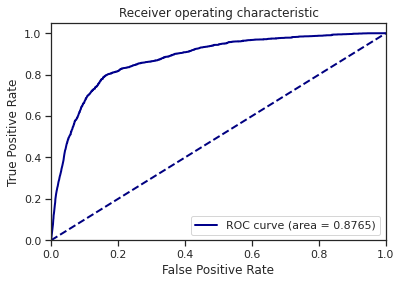

In [59]:
# graph
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
pred = clf.predict_proba(X_test)[:, 1]
#pred = clf.predict(X_test)

act               = y_test #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function

#model_logit_accuracy = metrics.accuracy_score(pred,act)  # error here: Classification metrics can't handle a mix of continuous and binary targets
#model_logit_accuracy = metrics.roc_auc_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

### Prob: AUC: 0.8765

In [60]:
pred.astype(float)

array([0.01199002, 0.01212056, 0.0147791 , ..., 0.00858033, 0.00743075,
       0.01510647])

##### Test validation data: 

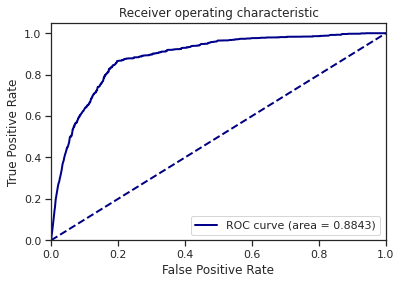

In [64]:
# graph
# how will it perform on the validation dataset?

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
pred = clf.predict_proba(X_valid)[:, 1]
#pred = clf.predict(X_test)

act               = y_valid #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function

#model_logit_accuracy = metrics.accuracy_score(pred,act)  # error here: Classification metrics can't handle a mix of continuous and binary targets
#model_logit_accuracy = metrics.roc_auc_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

### AUC: 0.8843
That's pretty good compared to others!

Baseline is:  0.01654248702040773
Accuracy (sklearn): 0.52942


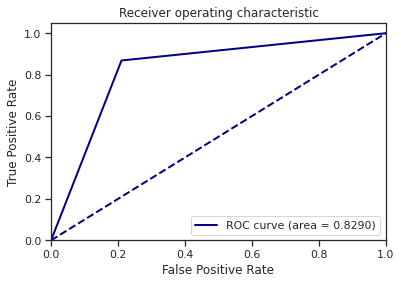

In [76]:
# graph
# how will it perform on the validation dataset?

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
pred = clf.predict_proba(X_valid)[:, 1]


#pred = clf.predict(X_valid)
p_baseline = np.mean(y_train)
print("Baseline is: ",p_baseline)
pred_bin = np.where(pred > p_baseline, 1, 0)


act               = y_valid #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function

#model_logit_accuracy = metrics.accuracy_score(pred,act)  # error here: Classification metrics can't handle a mix of continuous and binary targets
model_logit_accuracy = metrics.roc_auc_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

Even the binary prediction is still pretty good

In [89]:
print(sum(pred_bin))
print(sum(act))

print("TP: ", sum(pred_bin + act == 2))
print("TN: ", sum(pred_bin * act == 0))

print("FP: ", sum(pred_bin - act == 1))
print("FN: ", sum(pred_bin - act == -1))


36255
2567
TP:  2229
TN:  162120
FP:  34026
FN:  338


## III. Naive Bayes


In [92]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()
model.fit(X_train,y_train)  # use original data
#model.fit(X_smote,y_smote)  ## use oversample data
#model.fit(X_rus,y_rus)  ## use rus data

GaussianNB()

In [98]:
#pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]
pred = pred_proba

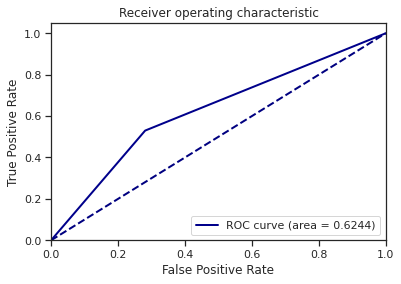

In [99]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

### for binary:

p_baseline = np.mean(y_train)
pred_bin = np.where(pred > p_baseline, 1, 0)
#pred_zero = [0 for i in range(len(pred))]


#pred              = pred[]] #column used for predicted
act = y_test

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

### AUC: 0.5010 on original data (0.6244 on binary, 0.6517 on proba)
### AUC: 0.5868 on RUS data
### AUC: 0.5594 on SMOTE data (0.6311 on proba)

## IV. KNN


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [270]:
from sklearn.model_selection import train_test_split


index_cols = ['y_qty', 'y_dscnt_pcode', 'redemption_id', 'date', 'c_type', 'c_id',]
feature_cols = df_train.drop(columns=index_cols + [target_col])

X = feature_cols
y = df_train['y_redeemed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)

print(X_train.columns)

X_train[:5]

Index(['year', 'cust_id', 'prod_id', 'manuf', 'brand_type', 'category',
       'price', 'dscnt_store', 'start_date', 'end_date', 'age_cohort',
       'marital_status', 'home_is_rental', 'n_family', 'no_of_children',
       'income_range', 'DayOfWeek', 'month', 'day', 'promo_duration',
       'promo_start', 'lnPrice'],
      dtype='object')


year  cust_id  prod_id  manuf   brand_type          category   price  \
543897  2013      634    28656    602  Established  Natural Products  156.37   
18498   2013     1475    16708    967  Established           Grocery   59.49   
232223  2013     1516    33448     56        Local           Grocery   70.88   
67601   2013       40    67629   3099  Established              Meat  314.17   
368655  2013      181    15227   2020  Established     Packaged Meat   89.05   

        dscnt_store start_date   end_date  ... home_is_rental n_family  \
543897         0.00 2013-02-16 2013-05-04  ...              0        5   
18498        -20.66 2013-02-16 2013-05-04  ...              0        3   
232223         0.00 2013-02-16 2013-05-04  ...             -1       -1   
67601       -157.80 2013-02-16 2013-05-04  ...              0        4   
368655       -53.07 2013-02-16 2013-05-04  ...             -1       -1   

        no_of_children  income_range  DayOfWeek  month  day  promo_duration  \
543897               3             5          3      2   21              77   
18498                2             1          1      3   12              77   
232223              -1            -1          4      3   22              77   
67601                2             7          2      3    6              77   
368655              -1            -1          4      3   15              77   

        promo_start   lnPrice  
543897            5  5.058600  
18498            24  4.102478  
232223           34  4.274998  
67601            18  5.753112  
368655           27  4.500365  

[5 rows x 22 columns]

In [28]:
from sklearn.preprocessing import StandardScaler

std_train = StandardScaler()

std_train.fit(X_train)
X_train_std    = std_train.transform(X_train)

#std_train.fit(X_rus)   #use undersample data
#X_train_std    = std_train.transform(X_rus)

#std_train.fit(X_smote)   #use undersample data
#X_train_std    = std_train.transform(X_smote)


In [34]:
model_knn = KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_train)

#model_knn.fit(X_train_std, y_rus)
#model_knn.fit(X_train_std, y_smote)


KNeighborsClassifier()

In [35]:
X_test_std    = std_train.transform(X_test)     # This is right!

In [36]:
#pred = model_knn.predict(X_test_std)
pred = model_knn.predict_proba(X_test_std)[:, 1]  # this could take a while!


KeyboardInterrupt: ignored

#### Prob: AUC: 0.7405 on imbalanced data

In [ ]:
act = y_test
fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

#### Prob: AUC: 0.6536 on SMOTE

In [ ]:
from sklearn.preprocessing import StandardScaler

std_train = StandardScaler()

std_train.fit(X_smote)   #use undersample data
X_train_std    = std_train.transform(X_smote)


model_knn = KNeighborsClassifier(n_neighbors=10, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_smote)

X_test_std    = std_train.transform(X_test)     # This is right!
pred = model_knn.predict_proba(X_test_std)[:, 1]

act = y_test
fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

#### AUC: 0.7043 on RUS data (k = 5)
#### AUC: 0.5071 on SMOTE data (k = 5) ???

In [51]:
# find the best parameter 
model_knn = KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_rus)
print('5:  Training accuracy score: %.3f' % model_knn.score(X_train_std, y_rus))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))
print("==============================================")

model_knn = KNeighborsClassifier(n_neighbors=10, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_rus)
print('10: Training accuracy score: %.3f' % model_knn.score(X_train_std, y_rus))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))
print("==============================================")

model_knn = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_rus)
print('20: Training accuracy score: %.3f' % model_knn.score(X_train_std, y_rus))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))
print("==============================================")
model_knn = KNeighborsClassifier(n_neighbors=50, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_rus)
print('50: Training accuracy score: %.3f' % model_knn.score(X_train_std, y_rus))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))
print("==============================================")
model_knn = KNeighborsClassifier(n_neighbors=100, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_rus)
print('100:Training accuracy score: %.3f' % model_knn.score(X_train_std, y_rus))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))
print("==============================================")
model_knn = KNeighborsClassifier(n_neighbors=200, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_rus)
print('200:Training accuracy score: %.3f' % model_knn.score(X_train_std, y_rus))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))
print("==============================================")

5:  Training accuracy score: 0.803
Test accuracy score:     0.642
10: Training accuracy score: 0.748
Test accuracy score:     0.680
20: Training accuracy score: 0.713
Test accuracy score:     0.648
50: Training accuracy score: 0.676
Test accuracy score:     0.622
100:Training accuracy score: 0.651
Test accuracy score:     0.612
200:Training accuracy score: 0.635


In [52]:
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))


Test accuracy score:     0.604


## V. Bagging Classifier


In [102]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier 


bc = BaggingClassifier(random_state=42)
bc.fit(X_train, y_train)

BaggingClassifier(random_state=42)

In [103]:
#pred = bc.predict(X_test)
pred_prob = bc.predict_proba(X_test)[: ,1]

#### AUC: 0.8215 (probability)

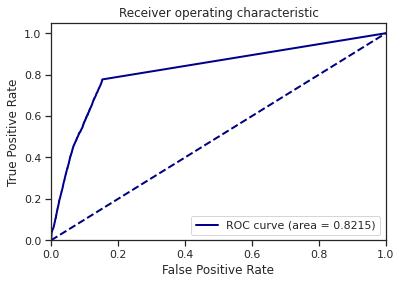

In [104]:
pred = pred_prob
act = y_test
fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)
#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

In [105]:
print(sum(pred_bin))
print(sum(act))

print("TP: ", sum(pred_bin + act == 2))
print("TN: ", sum(pred_bin * act == 0))

print("FP: ", sum(pred_bin - act == 1))
print("FN: ", sum(pred_bin - act == -1))


53537
3186
TP:  1688
TN:  186011
FP:  51849
FN:  1498


### Test validation data:


### AUC: 0.9393 (prob)
Wow!

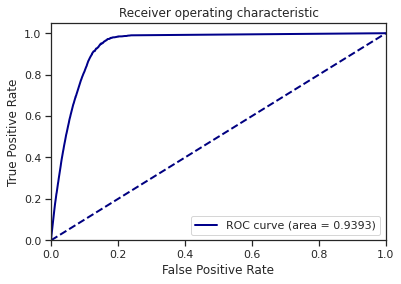

In [106]:
pred_prob = bc.predict_proba(X_valid)[: ,1]
pred = pred_prob


act = y_valid
fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)
#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)


In [108]:
print(sum(pred))
print(sum(act))

print("TP: ", sum(pred + act == 2))
print("TN: ", sum(pred * act == 0))

print("FP: ", sum(pred - act == 1))
print("FN: ", sum(pred - act == -1))

2764.3233862765296
2567
TP:  0
TN:  161808
FP:  0
FN:  26


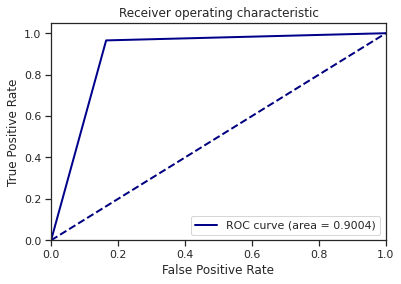

In [109]:


pred_prob = bc.predict_proba(X_valid)[: ,1]

p_baseline = np.mean(y_train)
pred_bin = np.where(pred_prob > p_baseline, 1, 0)



act = y_valid
fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)
#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)



In [110]:
print(sum(pred_bin))
print(sum(act))

print("TP: ", sum(pred_bin + act == 2))
print("TN: ", sum(pred_bin * act == 0))

print("FP: ", sum(pred_bin - act == 1))
print("FN: ", sum(pred_bin - act == -1))

29086
2567
TP:  2478
TN:  161871
FP:  26608
FN:  89


This is the best performance we can get.


# Part 4: Save the model with pickle

In [111]:
import pickle

In [115]:
s = pickle.dumps(bc)

clf2 = pickle.loads(s)

another_pred = clf2.predict_proba(X_valid)
another_pred = another_pred[:,1]


In [116]:
print(sum(another_pred))
print(sum(y_valid))

print("TP: ", sum(another_pred + y_valid == 2))
print("TN: ", sum(another_pred * y_valid == 0))

print("FP: ", sum(another_pred - y_valid == 1))
print("FN: ", sum(another_pred - y_valid == -1))

2764.3233862765296
2567
TP:  0
TN:  161808
FP:  0
FN:  26


In [117]:
from joblib import dump, load

In [118]:
dump(clf2, 'team_mauve.joblib') 

['team_mauve.joblib']

In [126]:
from google.colab import drive
drive.mount('drive')
#X_valid.to_csv('data.csv')
#y_valid.to_csv('data_answer.csv')


path = "/content/proj_training_data.csv"

### path_sup = "/content/proj_training_data_supl.csv"
# not in use for now


import pandas as pd
import numpy as np

df = pd.read_csv(path)

df_out = df[:50000]
df_out[:5]
print(len(df_out)) # should be 110284


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
1102842


In [128]:
df_out = df[:50000]
df_out[:5]

df_out.to_csv('data.csv')


In [129]:
X_valid.to_csv('data1.csv')

#Final Submission:  

# Part 5: interpolation on demographic data (unfinished)
Since we do not have sufficient data on the customers, can we predict the demographic data first, then predict their redemption?


We can use the "df" directly, extract the data with -1 (which means empty data) and predict these data using other known data (not including "y_" data).  

In [67]:
#recall our initial data
df[:10]

y_redeemed  year       date  cust_id  prod_id  manuf   brand_type category  \
0           0  2013 2013-02-22     1489    34047     56        Local  Grocery   
1           0  2013 2013-02-22     1489    35464     56        Local  Grocery   
2           0  2013 2013-03-03     1489    34047     56        Local  Grocery   
3           0  2013 2013-03-03     1489    33688    939  Established  Grocery   
4           0  2013 2013-03-05     1489    34047     56        Local  Grocery   
5           0  2013 2013-03-08     1489    57921    487  Established  Grocery   
6           0  2013 2013-03-08     1489    25795     56        Local  Grocery   
7           0  2013 2013-03-08     1489    26542     56        Local  Grocery   
8           0  2013 2013-03-08     1489    57881    487  Established  Grocery   
9           0  2013 2013-03-15     1489    24562    278  Established  Grocery   

   y_qty   price  ...  home_is_rental  n_family  no_of_children income_range  \
0      1   91.19  ...               0         2              -1            3   
1      1   21.02  ...               0         2              -1            3   
2      1   91.19  ...               0         2              -1            3   
3      1  124.31  ...               0         2              -1            3   
4      1   91.19  ...               0         2              -1            3   
5      2  118.61  ...               0         2              -1            3   
6      1   35.62  ...               0         2              -1            3   
7      1   35.62  ...               0         2              -1            3   
8      1   59.49  ...               0         2              -1            3   
9      1   71.24  ...               0         2              -1            3   

  DayOfWeek month  day promo_duration promo_start   lnPrice  
0         4     2   22             77           6  4.523852  
1         4     2   22             77           6  3.091951  
2         6     3    3             77          15  4.523852  
3         6     3    3             77          15  4.830791  
4         1     3    5             77          17  4.523852  
5         4     3    8             77          20  4.784236  
6         4     3    8             77          20  3.600595  
7         4     3    8             77          20  3.600595  
8         4     3    8             77          20  4.102478  
9         4     3   15             77          27  4.279994  

[10 rows x 29 columns]

In [1]:
target  = 'home_is_rental'

df_missing = df

df_missing = pd.concat([df_missing, ((pd.get_dummies(df_missing['category'], drop_first=True, prefix = "category")))], axis = 1, join = 'inner')
df_missing = pd.concat([df_missing, ((pd.get_dummies(df_missing['brand_type'], drop_first=True, prefix = "brand_type")))], axis = 1, join = 'inner')
df_missing = pd.concat([df_missing, ((pd.get_dummies(df_missing['DayOfWeek'], drop_first=True, prefix = "DOW")))], axis = 1, join = 'inner')
df_missing = pd.concat([df_missing, ((pd.get_dummies(df_missing['c_type'], drop_first=True, prefix = "c_type")))], axis = 1, join = 'inner')
df_full = df_missing[df_missing[target] != -1]
print(len(df_full))
df_missing = df_missing[df_missing[target] == -1]
print(len(df_missing))

df_full[:10]

NameError: ignored

In [72]:
index_cols = ['y_redeemed', 'y_qty', 'cust_id', 'y_dscnt_pcode', 'redemption_id', 'date', 'brand_type', 'category', 'c_type', 'c_id', 'marital_status', 'income_range', 'n_family', 'no_of_children', 'start_date', 'end_date', 'age_cohort']

#feature_cols = df_full.drop(columns=index_cols + ['home_is_rental'])

X = df_full.drop(columns = index_cols + [target])
y = df_full[target]

print(len(X))
X[:10]


717252


year  prod_id  manuf   price  dscnt_store  DayOfWeek  month  day  \
0  2013    34047     56   91.19         0.00          4      2   22   
1  2013    35464     56   21.02         0.00          4      2   22   
2  2013    34047     56   91.19         0.00          6      3    3   
3  2013    33688    939  124.31       -10.69          6      3    3   
4  2013    34047     56   91.19         0.00          1      3    5   
5  2013    57921    487  118.61       -23.87          4      3    8   
6  2013    25795     56   35.62         0.00          4      3    8   
7  2013    26542     56   35.62         0.00          4      3    8   
8  2013    57881    487   59.49       -11.75          4      3    8   
9  2013    24562    278   71.24       -17.45          4      3   15   

   promo_duration  promo_start  ...  category_Travel  \
0              77            6  ...                0   
1              77            6  ...                0   
2              77           15  ...                0   
3              77           15  ...                0   
4              77           17  ...                0   
5              77           20  ...                0   
6              77           20  ...                0   
7              77           20  ...                0   
8              77           20  ...                0   
9              77           27  ...                0   

   category_Vegetables (cut)  brand_type_Local  DOW_1  DOW_2  DOW_3  DOW_4  \
0                          0                 1      0      0      0      1   
1                          0                 1      0      0      0      1   
2                          0                 1      0      0      0      0   
3                          0                 0      0      0      0      0   
4                          0                 1      1      0      0      0   
5                          0                 0      0      0      0      1   
6                          0                 1      0      0      0      1   
7                          0                 1      0      0      0      1   
8                          0                 0      0      0      0      1   
9                          0                 0      0      0      0      1   

   DOW_5  DOW_6  c_type_Y  
0      0      0         0  
1      0      0         0  
2      0      1         0  
3      0      1         0  
4      0      0         0  
5      0      0         0  
6      0      0         0  
7      0      0         0  
8      0      0         0  
9      0      0         0  

[10 rows x 34 columns]

Missing columns: 'home_is_rental', 'marital_status', 'income_range', 'n_family', 'no_of_children', 'age_cohort'


In [73]:

X_train_missing, X_test_missing, y_train_missing, y_test_missing = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)


Accuracy (sklearn): 0.30397


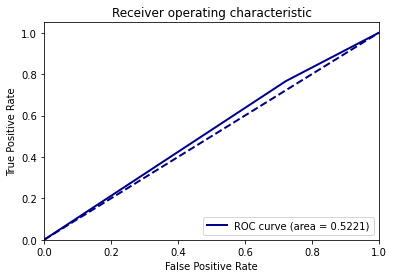

In [81]:
# use Naive Bayes?
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()
model.fit(X_train_missing,y_train_missing)  ## use oversample data

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score


pred = model.predict_proba(X_test_missing)[:, 1]
p_baseline = y_train_missing.mean()
pred_bin = np.where(pred > p_baseline, 1, 0)

act = y_test_missing

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


model_logit_accuracy = metrics.accuracy_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

In [74]:
from sklearn.preprocessing import StandardScaler

std_train = StandardScaler()

std_train.fit(X_train_missing)   #use undersample data
X_train_std    = std_train.transform(X_train_missing)


model_knn = KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_train_missing)

X_test_std    = std_train.transform(X_test_missing)     # This is right!
pred = model_knn.predict(X_test_std)

act = y_test_missing
fpr, tpr, _  = metrics.roc_curve(act, pred) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


#model_logit_accuracy = metrics.accuracy_score(pred,act)

#print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

KeyboardInterrupt: ignored

In [80]:
y_train_missing.mean()

0.05299398223425891

#(original logistic 下略)

In [ ]:
pd.set_option('display.max_columns', None)
df.head()


y_redeemed  year       date  cust_id  prod_id  manuf   brand_type category  \
0           0  2013 2013-02-22     1489    34047     56        Local  Grocery   
1           0  2013 2013-02-22     1489    35464     56        Local  Grocery   
2           0  2013 2013-03-03     1489    34047     56        Local  Grocery   
3           0  2013 2013-03-03     1489    33688    939  Established  Grocery   
4           0  2013 2013-03-05     1489    34047     56        Local  Grocery   

   y_qty   price  dscnt_store  y_dscnt_pcode  c_id c_type start_date  \
0      1   91.19         0.00            0.0     8      X 2013-02-16   
1      1   21.02         0.00            0.0     8      X 2013-02-16   
2      1   91.19         0.00            0.0     8      X 2013-02-16   
3      1  124.31       -10.69            0.0     8      X 2013-02-16   
4      1   91.19         0.00            0.0     8      X 2013-02-16   

    end_date  redemption_id age_cohort marital_status  home_is_rental  \
0 2013-05-04              9      46_55        Married               0   
1 2013-05-04              9      46_55        Married               0   
2 2013-05-04              9      46_55        Married               0   
3 2013-05-04              9      46_55        Married               0   
4 2013-05-04              9      46_55        Married               0   

   n_family  no_of_children  income_range  DayOfWeek  month  day  \
0         2              -1             3          4      2   22   
1         2              -1             3          4      2   22   
2         2              -1             3          6      3    3   
3         2              -1             3          6      3    3   
4         2              -1             3          1      3    5   

   promo_duration  promo_start  marital_status_Single  \
0              77            6                      0   
1              77            6                      0   
2              77           15                      0   
3              77           15                      0   
4              77           17                      0   

   category_Dairy, Juices & Snacks  category_Flowers & Plants  \
0                                0                          0   
1                                0                          0   
2                                0                          0   
3                                0                          0   
4                                0                          0   

   category_Garden  category_Grocery  category_Meat  category_Miscellaneous  \
0                0                 1              0                       0   
1                0                 1              0                       0   
2                0                 1              0                       0   
3                0                 1              0                       0   
4                0                 1              0                       0   

   category_Natural Products  category_Packaged Meat  category_Pharmaceutical  \
0                          0                       0                        0   
1                          0                       0                        0   
2                          0                       0                        0   
3                          0                       0                        0   
4                          0                       0                        0   

   category_Prepared Food  category_Salads  category_Seafood  \
0                       0                0                 0   
1                       0                0                 0   
2                       0                0                 0   
3                       0                0                 0   
4                       0                0                 0   

   category_Skin & Hair Care  category_Travel  category_Vegetables (cut)  \
0                          0                0                          0   
1 

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


df_train

#f   = 'y_redeemed ~ lnPrice + dscnt_store + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + home_is_rental_1 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + DOW_1 + DOW_2 + DOW_3 + DOW_4 + DOW_5 + DOW_6 + promo_start'
# Note: still having singuler matrix issue on the "dayofweek" columns

#f   = 'y_redeemed ~ lnPrice + month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + home_is_rental_1 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'
#f   = 'y_redeemed ~ month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + home_is_rental_1 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'
# note: if exclude null, run below:
f   = 'y_redeemed ~ month + day + dscnt_store + c_type_Y + promo_duration + category_Grocery + category_Meat + category_Pharmaceutical + category_Seafood + brand_type_Local + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_56_70 + age_cohort_71 +  marital_status_Single + home_is_rental_1 + home_is_rental_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration + promo_start'


model_ols_sm = smf.logit(f, data=df_train).fit()
print(model_ols_sm.summary())

         Current function value: 0.092816
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:             y_redeemed   No. Observations:               363558
Model:                          Logit   Df Residuals:                   363525
Method:                           MLE   Df Model:                           32
Date:                Tue, 26 Apr 2022   Pseudo R-squ.:                 0.07811
Time:                        03:26:57   Log-Likelihood:                -33744.
converged:                      False   LL-Null:                       -36603.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -6.9916      0.175    -39.899      0.000      -7.335      -6.648
month                      -0.0320      0.005     -6.402      0.000      -0.042      -0.022


R square is very low. Maybe we could include more variables and see what would change. 




# Make predictions on differenct models and check the accuracy

---




In [ ]:
pred = model_ols_sm.predict(df_test)


In [ ]:
pred[:5]

10    0.005898
11    0.006410
12    0.006001
23    0.005898
24    0.006410
dtype: float64

In [ ]:
#helper func
def plot_roc(fpr,tpr,roc_auc):
  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkblue",
      lw=lw,
      label="ROC curve (area = %0.4f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic")
  plt.legend(loc="lower right")
  plt.show()

Accuracy (sklearn): 0.66725


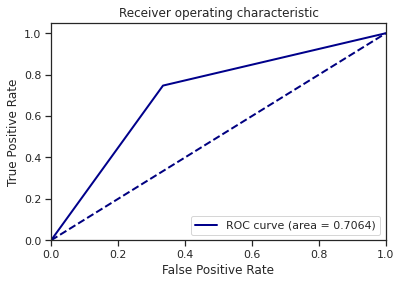

In [ ]:

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

p_baseline = np.mean(df_train['y_redeemed'])

pred_bin = np.where(pred > p_baseline, 1, 0)

pred_zero = [0 for i in range(len(pred))]

#pred              = pred[]] #column used for predicted
act               = df_test['y_redeemed'] #column used for actual

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


model_logit_accuracy = metrics.accuracy_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

##Fit a Tree Classsifier to model the probability:


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


col_names = ['lnPrice','year', 'month', 'day','manuf',
       'brand_type_Local', 'category_Grocery', 'category_Meat', 'category_Pharmaceutical', 'category_Seafood', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 
       'redemption_id', 'age_cohort', 'marital_status_Married', 'marital_status_Single', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration', 'promo_start', 'DayOfWeek']


col_names = ['lnPrice', 'c_type_Y','year', 'month', 'day', 'manuf', 'y_dscnt_pcode', 'prod_id',
       'brand_type_Local', 'category_Grocery', 'category_Meat', 'category_Pharmaceutical', 'category_Seafood', 'dscnt_store', 
       'age_cohort', 'marital_status_Married', 'marital_status_Single', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration', 'promo_start', 'DayOfWeek']


# if exclude nulls, then run below:
col_names = ['lnPrice', 'c_type_Y','year', 'month', 'day', 'manuf', 'y_dscnt_pcode', 'prod_id',
       'brand_type_Local', 'category_Grocery', 'category_Meat', 'category_Pharmaceutical', 'category_Seafood', 'dscnt_store', 
       'age_cohort', 'marital_status_Single', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration', 'promo_start', 'DayOfWeek']



feature_cols = df[col_names]

X = feature_cols
y = df['y_redeemed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)

X_train[:5]


lnPrice  c_type_Y  year  month  day  manuf  y_dscnt_pcode  prod_id  \
509100   4.680834         0  2013      3    6   1923           0.00    51506   
643636   5.260823         0  2013      4    4     56           0.00    34047   
430962   2.770086         1  2012      9   24   1149         -35.62    30256   
405280   4.102478         0  2013      4    4    440           0.00    71945   
1060773  3.107721         1  2012     11   14   1337           0.00    13637   

         brand_type_Local  category_Grocery  ...  dscnt_store  age_cohort  \
509100                  0                 1  ...       -92.26       36_45   
643636                  1                 1  ...         0.00       36_45   
430962                  0                 0  ...         0.00       36_45   
405280                  0                 1  ...       -11.40       46_55   
1060773                 0                 1  ...        -6.77       36_45   

         marital_status_Single  home_is_rental n_family  no_of_children  \
509100                       0               0        3               1   
643636                       0               0        2              -1   
430962                       1               0        2               1   
405280                       0               0        3               1   
1060773                      0               0        3               1   

         income_range  promo_duration  promo_start  DayOfWeek  
509100              6              77           18          2  
643636              6              77           47          3  
430962              4            1223         1079          0  
405280              6              77           47          3  
1060773             9             112           96          2  

[5 rows x 23 columns]

In [ ]:
tree_clf = DecisionTreeClassifier(min_samples_leaf=10)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

Accuracy (sklearn): 0.97966


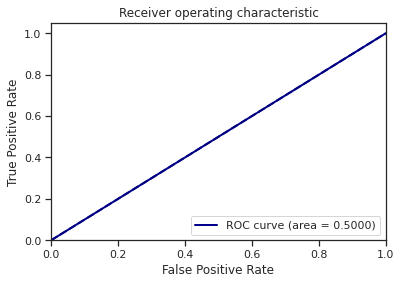

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

p_baseline = np.mean(df_train['y_redeemed'])

pred_bin = np.where(y_pred > p_baseline, 1, 0)

pred_zero = [0 for i in range(len(pred))]

#pred              = pred[]] #column to use for predicted
act               = y_test #column to use for actual

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


model_logit_accuracy = metrics.accuracy_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

Cross-validation:


In [ ]:
# cross-validation

from sklearn.model_selection import cross_val_score

target = "y_redeemed"

model = DecisionTreeClassifier(min_samples_leaf=10)
avg_auc = cross_val_score(model, X_train, y_train, cv = 10, scoring="roc_auc").mean()

print(avg_auc)

0.7607446860706539


Interesting. How can it be possible?

Something must be wrong?



In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test

696057    0
797087    0
398860    0
843066    0
775937    0
         ..
860948    0
6947      1
592873    0
839311    0
825676    0
Name: y_redeemed, Length: 220569, dtype: int64

In [ ]:
sum(y_pred)

0

In [ ]:
sum(y_test)

3566

In [ ]:
sum(y_pred != y_test)

3566

Looks very convincing to me. But we should be more careful on the validation.


Run the model again, now with validation dataset.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


col_names = ['year','manuf',
       'brand_type_Local', 'category_Grocery', 'category_Meat', 'category_Pharmaceutical', 'category_Seafood', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 
       'redemption_id', 'age_cohort', 'marital_status_Married', 'marital_status_Single', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration', 'DayOfWeek']

col_names = ['year', 'month', 'day', 'manuf',
       'brand_type_Local', 'category_Grocery', 'category_Meat', 'category_Pharmaceutical', 'category_Seafood', 'dscnt_store', 
       'age_cohort', 'marital_status_Married', 'marital_status_Single', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration', 'promo_start', 'DayOfWeek']


pre_data = df[df['date'] < '2013/4/8']
post_data = df[df['date'] >= '2013/4/8']
#feature_cols = pre_data.loc[:, pre_data.columns!= 'y_redeemed']

feature_cols = pre_data[col_names]

X = feature_cols
y = pre_data['y_redeemed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)

print(len(pre_data))
print(len(post_data))


997069
105773


In [ ]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

post_x = post_data[col_names]
y_pred = tree_clf.predict(post_x)



Accuracy (sklearn): 0.98617


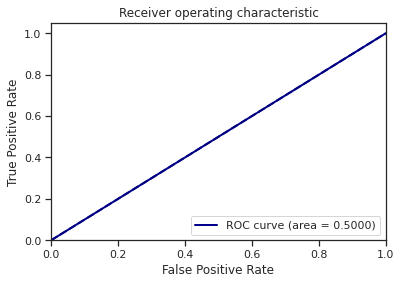

In [ ]:

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

p_baseline = np.mean(df_train['y_redeemed'])

pred_bin = np.where(y_pred > p_baseline, 1, 0)

pred_zero = [0 for i in range(len(pred))]

#pred              = pred[]] #column to use for predicted
act               = post_data['y_redeemed'] #column to use for actual

fpr, tpr, _  = metrics.roc_curve(act, pred_bin) ### use the roc_curve function
roc_auc           = metrics.auc(fpr, tpr) ### use the auc function


model_logit_accuracy = metrics.accuracy_score(pred_bin,act)

print("Accuracy (sklearn):" , np.round(model_logit_accuracy, 5))

plot_roc(fpr,tpr,roc_auc)

In [ ]:
sum(y_pred)

1562

In [ ]:
sum(act)

1463

In [ ]:
visualize_tree(tree_clf, col_names, ["no", "redeemed"])


#KNN


In [ ]:
def dist_euclidian(x1, x2):
    m = len(x1)
    sqr_dists     = [(x1[i]-x2[i])**2 for i in range(m)] 
    sum_sqr_dists = np.sum(sqr_dists)
    d             = np.sqrt(sum_sqr_dists)
    return d

In [ ]:
def calc_distances_for_all(x_new,X, dist_metric):
    n     = X.shape[0]
    dists = [dist_metric(x_new,X[i,:]) for i in range(n)]
    return(dists)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# scale the data! mean = 0 and std = 1

from sklearn.preprocessing import StandardScaler

# Variable scaling

std_train = StandardScaler()
std_train.fit(X_train)
X_train_std    = std_train.transform(X_train)
    
              
std_test_ng   = StandardScaler()                # This is wrong...!
std_test_ng.fit(X_test)                         # wrong...!
X_test_std_ng = std_test_ng.transform(X_test)   # wrong...!

X_test_std    = std_train.transform(X_test)     # This is right!

In [ ]:
print("PARAMETERS OF SCALERS")
print("========== == =======\n")

mu    = std_train.mean_
sigma = np.sqrt(std_train.var_)
print("means, sds from std_train   :\n    mean=", np.round(mu,2),"\n    sd=  ",  np.round(sigma,2))  
print("\n")
mu    = std_test_ng.mean_
sigma = np.sqrt(std_test_ng.var_)
print("means, sds from std_test    :\n    mean=", np.round(mu,2),"\n    sd=  ",  np.round(sigma,2))
print("\n")

print("SUMMARY STATISTICS OF SCALED/UNSCALED DATA")
print("======= ========== == =============== ====\n")
print("TRAINING DATA:")
print("     mean unstandardized:\n",   np.round(pd.DataFrame(X_train).describe(),2))
print("\n     mean standardized:\n",   np.round(pd.DataFrame(X_train_std).describe(),2))


print("\nTEST DATA:")
print("   mean unstandarized:\n",   np.round(pd.DataFrame(X_test).describe().T[['mean','std','50%']].T,2))
print("\n   mean standardized ng (wrong!):\n", np.round(pd.DataFrame(X_test_std_ng).describe().T[['mean','std','50%']].T,2))
print("\n mean standardized (correct):\n", np.round(pd.DataFrame(X_test_std).describe().T[['mean','std','50%']].T,2))

PARAMETERS OF SCALERS
========== == =======

means, sds from std_train   :
    mean= [ 4.420000e+00  8.000000e-02  2.012880e+03  3.740000e+00  1.574000e+01
  9.166700e+02 -1.440000e+00  3.050791e+04  2.300000e-01  6.700000e-01
  4.000000e-02  6.000000e-02  1.000000e-02 -2.308000e+01  3.612280e+03
  2.300000e-01  8.000000e-02  2.620000e+00  2.300000e-01  5.190000e+00
  1.279600e+02  7.235000e+01  3.240000e+00] 
    sd=   [7.200000e-01 2.700000e-01 3.200000e-01 2.530000e+00 8.710000e+00
 1.079380e+03 1.012000e+01 1.850365e+04 4.200000e-01 4.700000e-01
 1.900000e-01 2.300000e-01 1.000000e-01 3.952000e+01 1.364410e+03
 4.200000e-01 2.700000e-01 1.190000e+00 1.540000e+00 2.370000e+00
 2.165400e+02 1.970500e+02 1.930000e+00]


means, sds from std_test    :
    mean= [ 4.420000e+00  8.000000e-02  2.012880e+03  3.740000e+00  1.574000e+01
  9.103000e+02 -1.400000e+00  3.043545e+04  2.300000e-01  6.700000e-01
  4.000000e-02  6.000000e-02  1.000000e-02 -2.327000e+01  3.621450e+03
  2.300000e-01  

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=32, p=2, weights='uniform', algorithm='auto')
model_knn.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=32)

In [ ]:
print('Training accuracy score: %.3f' % model_knn.score(X_train_std, y_train))
print('Test accuracy score:     %.3f' % model_knn.score(X_test_std, y_test))

KeyboardInterrupt: ignored

In [ ]:
len(X_train_std)
len(y_train)

335636

## (Previous HW) Q1: Fit a statsmodel logit model to the data to estimate the probability that Sales will be 'low' for for a given day based on knowlege of observable day of the week and holiday features. Low being a standard deviation less than all sales. Use the code and baseline provided in HW 1 Solutions video

# 新增區段

Perform EDA on training data:

see sections below

In [ ]:
!pip install dataprep
import dataprep
from dataprep.eda import create_report

create_report(df_train).show()


The first thing we notice is that only 1.3% of the data are "Redeemed", that is pretty low. 

In other words, if we simply predict nobody will ever redeemed anything, then we would have a 99% accuracy! 




Further perform more EDA on those redeemed:


In [ ]:
df_redeemed = df_train[df_train['y_redeemed'] == 1]
create_report(df_redeemed).show()


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

dat = working_df

f = 'lowSalesFlag ~ Promo + SchoolHoliday + DayOfWeek_2 + DayOfWeek_3 + DayOfWeek_4 + DayOfWeek_5 + DayOfWeek_6 + DayOfWeek_7 + StateHoliday_a + StateHoliday_b + StateHoliday_c '

model_logit = smf.logit(f,data = dat).fit()
print(model_logit.summary())

mfx = model_logit.get_margeff()
print(mfx.summary())

In [ ]:
testing_df            = df_test[df_test["Open"] == 1] # eliminate observations for closed stores
testing_df['lnSales'] = np.log(testing_df["Sales"]+1)       # Take log add 1 to account for for zero sales days

mu = testing_df["lnSales"].mean()
sigma = testing_df["lnSales"].std()
x = np.array(testing_df["lnSales"])
z = (x - mu)/ sigma

testing_df['zSales'] = z #set to new column for z score
testing_df['lowSalesFlag'] = [1 if s <= -1 else 0 for s in testing_df['zSales']] # set low flag column where z score is low

testing_df = pd.concat([testing_df, ((pd.get_dummies(testing_df['DayOfWeek'], drop_first=True, prefix = "DayOfWeek")))], axis = 1, join = 'inner') #Use pd.get_dummies to convert 'DayOfWeek' to dummy variable
testing_df = pd.concat([testing_df, ((pd.get_dummies(testing_df['StateHoliday'], drop_first=True, prefix = "StateHoliday")))], axis = 1, join = 'inner') #Use pd.get_dummies to convert 'StateHoliday' to dummy variable 




# Helper function

def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

p_baseline           = np.mean(working_df['lowSalesFlag'])

# Calculate accuracy of statsmodels logit model using statsmodels pred.table (confusion matrix)

## Use the threshold above
logit_pred_tab     = model_logit.pred_table(p_baseline)
model_logit_accuracy  = cm2accuracy(logit_pred_tab)
print("Threshold:")
print(p_baseline)
## Use the threshold above

print("Confusion Matrix: Low Sales = 1)")
print(pd.DataFrame(np.round(logit_pred_tab,0)))
print("Accuracy (statsmodels): ",np.round(model_logit_accuracy,5))


#accuracy = (pred == true).mean()
#print(f"Accuracy: {accuracy:.2f}")

## Q2: Fit an sklearn Logit to the data, report your results as above. Were they significantly different? Why or why not? This question may require you checking out the documentation

In [ ]:
from sklearn.linear_model import LogisticRegression


feature_cols = ['Promo', 'Promo', 'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
X = working_df[feature_cols] # Features
y = working_df.lowSalesFlag # Target variable

X_test = testing_df[feature_cols]
y_test = testing_df.lowSalesFlag

clf = LogisticRegression(random_state=0).fit(X,y)
clf.predict(X_test)

#clf.predict_proba(X[:2, :])

print(clf.score(X, y))
print(clf.score(X_test, y_test))



In [ ]:
clf.predict_proba(X[:])


Yes, they are significantly different. The accuracy of statsmodel is around 0.54, while the score of sklearn reaches 0.86.

Although statsmodel and scikit-learn both use OLS model in this case, the reason that the two results are significantly different is due to their different approaches. 


The statsmodel provides a detailed statistical summary which is very similar to Stata and R. And the OLS in scikit-learn is much more focused on prediction, or machine learning ability rather than a plain summary. 

More specifically from their individual documentation, scikit-learn applies parameter regularization by default. It means adding extra information to the data in order to prevent overfitting. Meanwhile, statsmodel doesn't apply parameter regularization. And statsmodel doesn't include the intercept by default. 


## Q3 Fit a Tree Classifier (sklearn) to model the probability that sales will be low. What are the most important features? What does this tell you about the data?

In [ ]:
from sklearn.tree import DecisionTreeClassifier


feature_cols = ['Promo', 'Promo', 'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
X = working_df[feature_cols] # Features
y = working_df.lowSalesFlag # Target variable


X_test = testing_df[feature_cols]
y_test = testing_df.lowSalesFlag

model = DecisionTreeClassifier(max_depth=3, criterion="entropy")
model.fit(X,y)
pred = model.predict(X_test)
true = testing_df['lowSalesFlag']

print(f"Accuracy: {(pred == true).mean():.2f}")

In [ ]:
## helper function for visualization

import matplotlib.pylab as plt

def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]


def visualize_tree(decision_tree, feature_names, class_names, directory="/content/dsclass2022/Module_4_Trees/images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)
    

import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 
    

In [ ]:
### Print feature importances

from IPython.display import Image
from sklearn.tree import export_graphviz


visualize_tree(model, feature_cols, 'lowSalesFlag')

#tree_depth=1

#model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
#Decision_Surface(testing_df, "Promo", "SchoolHoliday", testing_df.lowSalesFlag, model)


From the tree above, we can tell that 'Promo' is the most important factor of all. It is located in the first node. By the greedy algorithm it uses, that means 'Promo' is the factor with the highest information gain.  

Secondly, DayOfWeek_5 and DayOfWeek_4 are located in the second level, which means they have the second largest information gain. 

Within this classification tree with three levels, we can tell which variables have the greater influence than others. 


## Q4 (Regression Trees) Let's build a regression tree to model Log Sales. Compare it with a Linear Regression -- does it work better?

In [ ]:
## Helper function
def report_reg_results(model,train_X,train_Y,test_X,test_Y):
    model.fit(train_X,train_Y)

    pred = model.predict(test_X)
    act = test_Y
    errors    = pred - act
    err       = np.array(errors)

    err2      = np.mean(err**2)
    MAD       = np.abs(np.median(err))
    RMS       = np.sqrt(np.mean(err2))
    r         = np.corrcoef(act,pred)[0,1]
    pseudo_R2 = r**2

    print('RMS = %.3f; MAD= %.3f; pseudo-R2 = %.3f' % (RMS,MAD,pseudo_R2))

    pred_df = pd.DataFrame({"actual":act, "predicted":pred})
    plt_df  = pred_df.sample(n=1000, replace=False, random_state=123).sort_index()
    plt_min = np.min(np.min(plt_df))
    plt_max = np.max(np.max(plt_df))
    plt_col = np.where(plt_df['actual']<plt_df['predicted'],"red","blue")

    fig, ax = plt.subplots()
    ax.scatter(plt_df['actual'], y=plt_df['predicted'],c=plt_col)
    ax.set_xlim(plt_min,plt_max)
    ax.set_ylim(plt_min,plt_max)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("lnSales: Actual vs. Predicted")
    fig
    print(pred_df.describe())

In [ ]:
from sklearn.tree import DecisionTreeRegressor
feature_cols = ['Promo', 'Promo', 'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
X = working_df[feature_cols] # Features
y = working_df.lnSales # Target variable

X_test = testing_df[feature_cols]
y_test = testing_df.lnSales

model = DecisionTreeRegressor(random_state=0)
model.fit(X,y)

print("The model training score is" , model.score(X, y))

report_reg_results(model, X, y, X_test, y_test)

Yes, it does perform better - but only slightly better. 

Recall the result from the linear model, we have:

RMS = 0.386; MAD = 0.033; pseudo-R2 = 0.179

Despite the tiny improvement of MAD (0.003) and pseudo-R2 (0.005), the result using a decision tree regressor still performs poorly with a pseudo-R2 = 0.184 , which barely explains anything.


## Q5: Discuss your results. Why are the predictors performing similarly in both classification and regression? What do you think can make them better?

The pseudo-R2 for both predictors are both around 0.18. The classification only slightly improves the performance. 

Here the target variable (lnSales) is a continuous value ranging around [8.5, 9.5], however, all the feature variables (X) are binary. This means most change of the variables are small relative to the intercept, and it is hard for these coefficients to affect the result from the high constant of lnSales. Even if we introduce the classification, the X variables still lack explanatory power. 

We can probably change to a better model or gain some more useful data to make the prediction better. 

## Part 2

# Predicting Churn

After discussing the churn problem at TelCo with Henrietta for a while (remember, from your pre-class assignment?), you've finally defined an adequate target variable for churn and gathered relevant data to predict it. Moreover, the marketing department has come up with an amazing retention offer: the offer is guaranteed to convince customers to extend their contract for an extra year after receiving it. Unfortunately, the offer is quite expensive; it costs $200. 

You've been authorized to give the retention offer to up to 25% of the customers whose contract is expiring. It is your job to use data from previous contract expirations to build a churn predictive model and make a recommendation of whom to target with the offers. The historical data includes:

- Gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
a- tenure: Number of months the customer has stayed with the company
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges: The amount charged to the customer monthly
- Churn: Whether the customer churned or not shortly after contract expiration (Yes or No)

__1. Load the churn data. The code below will also transform your categorical variables into dummy variables. No points for this. This is just meant to help you get started.__

In [ ]:
import numpy as np
import pandas as pd

# Just change the path below so that it points to your file.
data_path = "/content/dsclass2022/Homeworks/data-hw2.csv" 
#data_path = "https://raw.githubusercontent.com/bwolfson2/dsclass2022/main/Homeworks/data-hw2.csv"
df = pd.read_csv(data_path)
df = pd.get_dummies(df, drop_first=True)

print(df.columns)

__2. Split the data into 80% training data and 20% test data.__

In [ ]:
# Your code goes here

from sklearn.model_selection import train_test_split # Import train_test_split function

feature_cols = df.loc[:, df.columns!= 'Churn_Yes']


X = feature_cols # Features
y = df['Churn_Yes'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=0) # 80% training and 20% testing

X_train[:10]


__3. Build the best model you can for each of the following three model types:__
- __A decision tree classifier. Try different values for the parameter min_samples_leaf.__
- __A logistic regression. Try different values for the parameter C.__
- __A third model of your choice. Some suggestions: KNN, SVM, etc. Try different paramater values for this one too.__

__Optimize in terms of their generalization performance using ROC Area and cross-validation with 10 folds. Remember to use only the training data (do not use the test data at all for this example). For each of these model types, you should report the best parameter value you found and the corresponding ROC Area in the cross-validation. Your code should also show the process you went through to try different complexity parameter(s) for each model type. Pick one model to move forward with. Why did you select this one?__

__HINT: There is an example below of the ROC Area for a DecisionTreeClassifier using cross validation.__  

###3.1 Decision Tree Classifier:

In [ ]:
# 1. decision tree classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

target = "Churn_Yes"
#predictors = training_data.columns[training_data.columns != target]

#print(predictors)
example_model = DecisionTreeClassifier()
# Remember to only use the training data here!!
#avg_auc = cross_val_score(example_model, training_data[predictors], training_data[target], cv=10, scoring="roc_auc").mean()
avg_auc = cross_val_score(example_model, X_train, y_train, cv=10, scoring="roc_auc").mean()
print(avg_auc)


####

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_train)


In [ ]:
# try different parameters:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
#%matplotlib inline

# testing on 2^n as parameters
min_samples_leaf = [(2 ** i) for i in range(10)]

# plot different result from different parameters
for j in min_samples_leaf:
    tree_clf = DecisionTreeClassifier(min_samples_leaf = j)
    train_sizes, train_scores, test_scores = learning_curve(tree_clf, X_train, y_train, cv=5)
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = "Training")
    plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = "Cross-Validated")
    plt.title("Min samples leaf = " + str(j))
    plt.legend()

In [ ]:
range_leaf = [(2**i) for i in range(12)]

print(range_leaf)

accuracy_roc = []
accuracy_f1 = []
accuracy_scores = []
accuracy_precision = []
accuracy_balanced = []
accuracy_recall = []



for j in range_leaf:
  tree_clf = DecisionTreeClassifier(min_samples_leaf = j)
  tree_clf.fit(X_train, y_train)
  y_pred = tree_clf.predict(X_train)

  roc = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="roc_auc", cv=5))
  f1 = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="f1", cv=5))
  accu = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="accuracy", cv=5))
  precision = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="average_precision", cv=5))
  balanced = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="balanced_accuracy", cv=5))
  recall = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="recall", cv=5))


  accuracy_roc.append(roc)
  accuracy_f1.append(f1)
  accuracy_scores.append(accu)
  accuracy_precision.append(precision)
  accuracy_balanced.append(balanced)
  accuracy_recall.append(recall)




ticks = range_leaf
labels = ['{}'.format(v) for v in ticks]
  
plt.plot(range_leaf, accuracy_roc, label = "ROC_AUC")
plt.plot(range_leaf, accuracy_f1, label = "F1")
plt.plot(range_leaf, accuracy_scores, label = "Accuracy")
plt.plot(range_leaf, accuracy_precision, label = "Precision")
plt.plot(range_leaf, accuracy_balanced, label = "Balanced")
plt.plot(range_leaf, accuracy_recall, label = "Recall")


plt.xlabel('Leaf Samples for Decision Tree')
plt.ylabel('Training Score')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.legend();


Here the graph shows the model has most accuracy around 64 leaves. Then the accuracy drops. 

Therefore, we take 64 as our parameter and calculate the accuracy below:


In [ ]:
# print the accuracy of 64 leaves


tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy - 64 Leafs: ", accuracy_cv.round(3))
print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
print("F1 - 64 Leafs:       ", f1.round(3))

In [ ]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Remember to use the training data here!! 

tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy - 64 Leafs: ", accuracy_cv.round(3))
print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
print("F1 - 64 Leafs:       ", f1.round(3))


# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()



###3.2 Logistic Regression:

In [ ]:
## 2. logistic regression

c_range = [(10**i) for i in range(-3, 4)]
#c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#ticks = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

print(c_range)

accuracy_roc = []
accuracy_f1 = []
accuracy_scores = []
accuracy_precision = []
accuracy_balanced = []
accuracy_recall = []

for c in c_range:
  log_reg = LogisticRegression(C=c)
  log_reg.fit(X_train, y_train)
  y_pred_log = log_reg.predict(X_train)

  roc = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="roc_auc", cv=5))
  f1 = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="f1", cv=5))
  accu = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="accuracy", cv=5))
  precision = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="average_precision", cv=5))
  balanced = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="balanced_accuracy", cv=5))
  recall = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="recall", cv=5))


  accuracy_roc.append(roc)
  accuracy_f1.append(f1)
  accuracy_scores.append(accu)
  accuracy_precision.append(precision)
  accuracy_balanced.append(balanced)
  accuracy_recall.append(recall)


ticks = c_range
labels = ['{}'.format(v) for v in ticks]
  
plt.plot(c_range, accuracy_roc, label = "ROC_AUC")
plt.plot(c_range, accuracy_f1, label = "F1")
plt.plot(c_range, accuracy_scores, label = "Accuracy")
plt.plot(c_range, accuracy_precision, label = "Precision")
plt.plot(c_range, accuracy_balanced, label = "Balanced")
plt.plot(c_range, accuracy_recall, label = "Recall")


plt.xlabel('Leaf Samples for Decision Tree')
plt.ylabel('Training Score')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.legend();




It seems that the accuracy reaches the peak when c reaches 0.1 and the accuracy does not increase furthermore as c increases. 

The accuracy remains the same even if we increase the c to 1000.
Therefore, we pick c = 0.1 and run the result.

In [ ]:
# confirm accuracy and ROC AUC scores @ C = 0.1
log_reg_c = LogisticRegression(max_iter=1000, C=0.1)
log_reg_c.fit(X_train, y_train)
y_pred_c = log_reg_c.predict(X_train)
accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy:", accuracy_cv.round(3))
print("ROC AUC:", roc_auc.round(3))
print("F1:", f1.round(3))

In [ ]:

probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

plt.figure(figsize=(10, 10))
plt.plot(fpr2, tpr2, label="Log Regression")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

###3.3 KNN:

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

k_range = [2**i for i in range(10)] # from 1 to 512


# store results
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []
AUC_scores = []

# loop function for cross validation
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred_knn = knn.predict(X_train)
  scores = accuracy_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy").mean())
  f1 = F1_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="f1").mean())
  avg_precision = precision_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="average_precision").mean())
  recall = recall_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="recall").mean())
  avg_auc = AUC_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="roc_auc").mean())

# plot graph
ticks = [1, 5, 10, 30, 50, 75, 100]
ticks = k_range
labels = ['{}'.format(v) for v in ticks]
  
plt.plot(k_range, accuracy_scores, label = "Accuracy")
plt.plot(k_range, precision_scores, label = "Precision")
plt.plot(k_range, recall_scores, label = "Recall")
plt.plot(k_range, F1_scores, label = "F1")
plt.plot(k_range, AUC_scores, label = "AUC")

plt.xlabel('Value of K for KNN')
plt.ylabel('Training Score')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.legend();

The accuracy seems to reach the peack when K is around 64.

Therefore, we pick 64 as our parameter and check its result.


In [ ]:
# check accuracy and ROC AUC scores when K = 64 
# K = 64
knn_64 = KNeighborsClassifier(n_neighbors=64)
knn_64.fit(X_train, y_train)
y_pred_knn_64 = knn.predict(X_train)
accuracy_cv_64 = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc_64 = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1_64 = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy - K=64 :", accuracy_cv_64.round(3))

print("ROC AUC - K=64  :", roc_auc_64.round(3))

print("F1 - K=64       :", f1_64.round(3))



In [ ]:
probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)

plt.figure(figsize=(10, 10))
plt.plot(fpr3, tpr3, label="KNN")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()


Overall, the accuracy from all three models shows a relatively good result. 

They show concave shape as expected and their ROC AUC are high (around 0.8).

Among all, the logistic regression shows the better result since the ROC AUC is the highest (0.844), therefore I would pick this model and continue. 



__4. Use your test data to plot the ROC Curves for each of the three best models you found in the previous question (make sure to plot the three curves together). Would you consider changing the selected model after looking at the curves? If yes, explain why. If not, explain what would the curves need to look like for you to consider changing the selected model.__

__HINT: There is an example below of the ROC curve for the DecisionTreeClassifier that was used earlier__

In [ ]:
# The code below is just meant as an example for you to plot the ROC curve.
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Remember to use the training data here!! 
#example_model.fit(training_data[predictors], training_data[target])
example_model.fit(X_train, y_train)

# And to use the test data here!!
#probs = example_model.predict_proba(testing_data[predictors])[:, 1]
#fpr, tpr, thresholds = roc_curve(testing_data[target], probs)
probs = example_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


plt.plot(fpr, tpr, label="An Example")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

In [ ]:
tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="accuracy").mean()

print("Accuracy - 64 tree leaves   : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="accuracy").mean()
print("Accuracy - Logistic Regression : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="accuracy").mean()
print("Accuracy - 64 KNN       : ", accuracy_cv.round(3))

#roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
#f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

#print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
#print("F1 - 64 Leafs:       ", f1.round(3))




# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)



plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.plot(fpr2, tpr2, label="Log Regression")
plt.plot(fpr3, tpr3, label="KNN")

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()


In [ ]:
tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()

print("ROC_AUC - 64 tree leaves   : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("ROC_AUC - Logistic Regression : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("ROC_AUC - 64 KNN       : ", accuracy_cv.round(3))

#roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
#f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

#print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
#print("F1 - 64 Leafs:       ", f1.round(3))




# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)



plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.plot(fpr2, tpr2, label="Log Regression")
plt.plot(fpr3, tpr3, label="KNN")

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()


In [ ]:
tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

print("F1 - 64 tree leaves   : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="f1").mean()
print("F1 - Logistic Regression : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="f1").mean()
print("F1 - 64 KNN       : ", accuracy_cv.round(3))

#roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
#f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

#print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
#print("F1 - 64 Leafs:       ", f1.round(3))




# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)



plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.plot(fpr2, tpr2, label="Log Regression")
plt.plot(fpr3, tpr3, label="KNN")

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

Base on the graphs above, the best model is the linear regression, which has the highest accuracy of all. 

The performance of KNN is slightly lower than decision tree and log regression in this case. 

Overall, I would consider using Logistic Regression model since it has the hightest accuracy, F1, and ROC. 

In terms of changing models, I would consider changing the models if the ROC curve of the chosen model is lower than others, or if the curve is not concave. 